In [1]:
# Import relevant library
import tensorflow as tf
hello = tf.constant('Hello, TensorFlow!')
sess = tf.Session()
print(sess.run(hello))

b'Hello, TensorFlow!'


In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Read Data

In [3]:
# Download from https://www.bankofcanada.ca/rates/interest-rates/bond-yield-curves/
dataset = pd.read_csv('yield_curves_20190730.csv', parse_dates = ['Date'], encoding='utf-8')

# select corresponding yield curve columns
dataset = dataset[['Date', ' ZC100YR',' ZC200YR',' ZC300YR',' ZC500YR',' ZC1000YR',' ZC1500YR',' ZC2000YR',' ZC3000YR']]

# drop na column
dataset = dataset[dataset[' ZC3000YR'] != ' na']
print("The daily yield curve shape is ", dataset.shape)

# rename the column
dataset.columns = ['Date','1YR','2YR','3YR','5YR','10YR','15YR','20YR','30YR']

The daily yield curve shape is  (7052, 9)


In [4]:
dataset.head()

,Date,1YR,2YR,3YR,5YR,10YR,15YR,20YR,30YR
1305,1991-01-02,0.1048713100,0.1026496500,0.1015680000,0.0991824860,0.0994143380,0.1013164600,0.0982300860,0.1150025500
1306,1991-01-03,0.1035826700,0.1013430200,0.1006083700,0.0987608660,0.0991346330,0.1007015600,0.0973761820,0.1147669600
1307,1991-01-04,0.1025263300,0.1005515900,0.0998932600,0.0982866480,0.0992348550,0.1015744000,0.0990661690,0.1154664800
1308,1991-01-07,0.1031550600,0.1016053500,0.1009812000,0.0993536840,0.1005140200,0.1032523700,0.1008646000,0.1175229100
1309,1991-01-08,0.1028750400,0.1018181600,0.1011851500,0.0995092250,0.1008084300,0.1036376800,0.1012655700,0.1177263400


# Plot Yield Curve

In [5]:
# Convert yield curve data to numeric and scale it for drawing
# dataset = dataset.drop(['Week_num','Year'],axis=1)
cols = dataset.columns.drop('Date')
dataset[cols] = dataset[cols].apply(pd.to_numeric, errors='coerce')
dataset[cols] = dataset[cols]*100 #scale it
dataset_for_draw = dataset.copy()
dataset_for_draw.set_index('Date',inplace=True)

<Figure size 43200x28800 with 0 Axes>

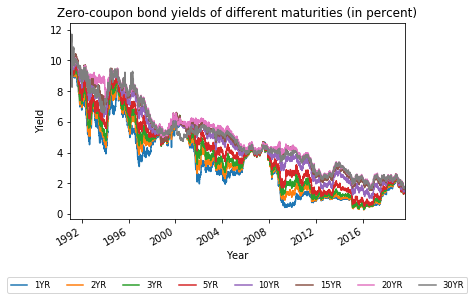

In [6]:
plt.figure(figsize=(600,400))
dataset_for_draw.plot()
plt.title("Zero-coupon bond yields of different maturities (in percent)", loc='center', fontsize=12, fontweight=0, color='black')
plt.xlabel("Year")
plt.ylabel("Yield")
plt.legend(loc="lower center", fontsize='small',bbox_to_anchor = (0.5, -0.4), ncol=8)

#plt.savefig('Yield.png', bbox_inches = 'tight',dpi = 600)
plt.show()

# Examine Input data
Create weekly input data

In [7]:
# assign the week number and year number
dataset['Week_num']=dataset['Date'].dt.week
dataset['Year']=dataset['Date'].dt.year

# construct weekly data by retriving the earliest date within a week 
Weekly_data= dataset.loc[dataset.groupby(['Week_num','Year'])['Date'].idxmin()]

# sort them based on date
Weekly_data = Weekly_data.sort_values(by = ['Date'])

# shows the structure
Weekly_data.head()

,Date,1YR,2YR,3YR,5YR,10YR,15YR,20YR,30YR,Week_num,Year
1305,1991-01-02,10.487131,10.264965,10.156800,9.918249,9.941434,10.131646,9.823009,11.500255,1,1991
1308,1991-01-07,10.315506,10.160535,10.098120,9.935368,10.051402,10.325237,10.086460,11.752291,2,1991
1313,1991-01-14,10.137836,10.071590,10.047878,9.952084,10.051866,10.357459,10.137006,11.839474,3,1991
1318,1991-01-21,10.174139,9.904986,9.811666,9.857239,9.885785,10.218911,9.947249,11.635473,4,1991
1323,1991-01-28,9.928108,9.718699,9.699274,9.828346,9.819840,10.145360,9.898416,11.631588,5,1991


In [8]:
#shows statis summary
Weekly_data = Weekly_data.drop(['Week_num','Year'],axis=1)
Weekly_data.describe()

,1YR,2YR,3YR,5YR,10YR,15YR,20YR,30YR
count,1489.000000,1489.000000,1489.000000,1489.000000,1489.000000,1489.000000,1489.000000,1489.000000
mean,3.352857,3.614993,3.825323,4.152264,4.682558,5.018664,5.180935,4.970151
std,2.292318,2.340012,2.357369,2.358697,2.326325,2.313723,2.313828,2.262255
min,0.299770,0.304250,0.337350,0.514460,1.045550,1.541370,1.688150,1.613330
25%,1.098683,1.367886,1.624500,1.972953,2.489810,2.867880,3.049922,3.037779
50%,2.991516,3.367829,3.692801,4.048880,4.417328,4.587505,4.839250,4.658990
75%,4.933644,5.183026,5.394543,5.767589,6.020576,6.261112,6.256383,5.848662
max,10.487131,10.264965,10.156800,9.952084,10.142583,10.421575,10.151304,11.839474


In [9]:
print("The weekly yield curve shape is",Weekly_data.shape)

The weekly yield curve shape is (1489, 9)


# Prepare Input for PCA

In [10]:
# Convert yield curve data to numeric
#cols = Weekly_data.columns.drop('Date')
#Weekly_data[cols] = Weekly_data[cols].apply(pd.to_numeric, errors='coerce')

#Prepare Input yield curve
w_data = Weekly_data.values
X = w_data[:,1:9]

# Principle Component Analysis
## Find the biggest variance in the 1st PC

In [11]:
# choose only 3 components
n_comp = 3
pca = PCA(n_components=n_comp)
pca.fit(X)  
print(" The variance ratio: ", pca.explained_variance_ratio_) 

 The variance ratio:  [0.96790749 0.02848438 0.00201113]


In [12]:
# Get the eigen Vector
eigVec = pca.components_
print("The eigen Vector is ", eigVec)

The eigen Vector is  [[ 0.34039971  0.35565537  0.3619667   0.36445498  0.35823976  0.35352307
   0.35071282  0.34274802]
 [ 0.56939889  0.40201807  0.26070077  0.06326356 -0.20330159 -0.3289942
  -0.40081391 -0.36328873]
 [ 0.39513307 -0.02779955 -0.23481271 -0.35429713 -0.21131212 -0.07854956
  -0.19093507  0.75838943]]


In [13]:
# find the biggest variance in the 1st PC
PCA_indicator = np.argmax(eigVec[0,:])
print("PCA 1st compoenent : ", Weekly_data.columns[PCA_indicator+1])

PCA 1st compoenent :  5YR


# Plot PCA Curve

In [14]:
x_label = np.array(['1Y','2Y','3Y','5Y','10Y','15Y','20Y','30Y'])
#construct the eigen-Vectors
df = pd.DataFrame({'Tenors':x_label,'PC1':eigVec[0,:], 'PC2':eigVec[1,:],'PC3':eigVec[2,:]})  
df

,Tenors,PC1,PC2,PC3
0,1Y,0.340400,0.569399,0.395133
1,2Y,0.355655,0.402018,-0.027800
2,3Y,0.361967,0.260701,-0.234813
3,5Y,0.364455,0.063264,-0.354297
4,10Y,0.358240,-0.203302,-0.211312
5,15Y,0.353523,-0.328994,-0.078550
6,20Y,0.350713,-0.400814,-0.190935
7,30Y,0.342748,-0.363289,0.758389


/Users/Veronica/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: Second argument 'PC1' is ambiguous: could be a color spec but is in data; using as data.  Either rename the entry in data or use three arguments to plot.
  
/Users/Veronica/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: Second argument 'PC2' is ambiguous: could be a color spec but is in data; using as data.  Either rename the entry in data or use three arguments to plot.
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/Veronica/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: Second argument 'PC3' is ambiguous: could be a color spec but is in data; using as data.  Either rename the entry in data or use three arguments to plot.
  after removing the cwd from sys.path.


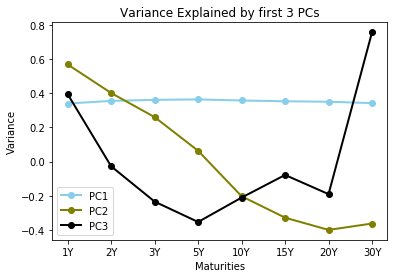

In [15]:
# plot
plt.plot('Tenors', 'PC1', data=df, marker='o',color='skyblue', linewidth=2)
plt.plot('Tenors', 'PC2', data=df, marker='o', color='olive', linewidth=2)
plt.plot('Tenors', 'PC3', data=df, marker='o', color='black', linewidth=2)

plt.title('Variance Explained by first 3 PCs', loc='center', fontsize=12, fontweight=0, color='black')
plt.xlabel('Maturities')
plt.ylabel('Variance')

plt.legend(loc='lower left')

#plt.savefig('F2_Variance.png', bbox_inches = 'tight',dpi = 600)
plt.show()

# Constructed Input/ Output for ANN

In [16]:
#Construct the input for ANN
w_data = Weekly_data.values
X = w_data[:,1:9]

Output_Y = Weekly_data.diff()
Y = Output_Y.values

Y = Y[1:,1:9] 
X = X
Y = Y*100 #scale it to the same level

N_points = len(Y)
PCA_indicator = np.argmax(eigVec[0,:])
Delta_move = Y[:,PCA_indicator]
newX = np.c_[X[0:N_points,:], Delta_move]

In [17]:
Y_describe = pd.DataFrame(Y)
Y_describe = Y_describe.apply(pd.to_numeric, errors='coerce')
Y_describe.describe()

,0,1,2,3,4,5,6,7
count,1488.000000,1488.000000,1488.000000,1488.000000,1488.000000,1488.000000,1488.000000,1488.000000
mean,-0.587371,-0.577686,-0.573587,-0.560248,-0.560321,-0.567494,-0.542085,-0.656305
std,15.745892,15.952249,15.042793,14.065159,12.154566,11.439596,10.338101,14.737845
min,-92.351310,-87.990260,-83.696280,-66.750800,-38.486360,-61.536680,-49.123750,-170.791720
25%,-6.116948,-7.474035,-7.860750,-8.178018,-7.787697,-6.729533,-6.466603,-6.322613
50%,-0.036085,-0.392160,-0.582700,-0.611720,-0.976145,-0.818645,-0.846785,-0.646375
75%,4.819973,6.540610,6.575520,6.705842,6.069757,5.214600,4.872183,5.024833
max,111.571350,111.989930,110.300620,95.977580,57.011390,65.215170,51.233200,112.607320


In [18]:
#Check output
print("The input first row is ", newX[0])
print("The input second row is ",newX[1])

print("The original output is ", Y[0])
#print("The scaled output is ", Y_Tr[0])
#print(Weekly_data.iloc[0:2])

The input first row is  [10.487131 10.264965 10.1568 9.9182486 9.9414338 10.131646 9.8230086
 11.500255 1.7119799999999685]
The input second row is  [10.315506000000001 10.160535 10.09812 9.9353684 10.051402 10.325237
 10.08646 11.752291 1.6715900000001227]
The original output is  [-17.16249999999988 -10.443000000000069 -5.868000000000073
 1.7119799999999685 10.996819999999907 19.359099999999962 26.3451400000001
 25.203600000000037]


# ANN

In [19]:
from numpy import array
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.embeddings import Embedding
from keras.wrappers.scikit_learn import KerasRegressor
from keras import regularizers
from keras.optimizers import SGD
from keras.layers.core import Dropout
from keras.constraints import max_norm
from keras.callbacks import ModelCheckpoint
import keras.backend as K

Using TensorFlow backend.


# Split Test / Validation /  Train Set

In [20]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train_tr, y_test_tr = train_test_split(newX, Y, test_size=0.3, random_state=np.random)
X_train, X_val,y_train_tr, y_val_tr = train_test_split(X_train, y_train_tr, test_size=0.2, random_state=np.random)

In [49]:
# for scaled output
#from sklearn.model_selection import train_test_split
#X_train, X_test, y_train, y_test = train_test_split(newX, Y_Tr, test_size=0.3, random_state=np.random)
#X_train, X_val,y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=np.random)

# Scaled Data

In [21]:
from sklearn.preprocessing import MinMaxScaler
# set the range from -1 to 1, apply on training set
scaler = MinMaxScaler(feature_range = (-1,1))
scaler.fit(y_train_tr)

y_train = scaler.transform(y_train_tr) #scaled data
y_val = scaler.transform(y_val_tr)
y_test = scaler.transform(y_test_tr)

# scaled output
#minInRows = np.amin(Y, axis=1)
#maxInRows = np.amax(Y, axis=1)

#minInRows = minInRows[:, np.newaxis]
#maxInRows = maxInRows[:, np.newaxis]
#Y_Tr = 10*(Y-minInRows)/(maxInRows-minInRows)

/Users/Veronica/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype object was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


In [22]:
#Check output
print("The scaled output is ", y_train[0])


The scaled output is  [-0.10460848 -0.17706589 -0.20690197 -0.27095937 -0.35208191 -0.14884587
 -0.13376894 -0.10033694]


# Define Customized Loss Function

In [23]:
def vector_mse(yTrue, yPred):
    c = K.constant([0.11,0.11,0.13,0.2,0.12,0.11,0.11,0.11])
    return K.mean(c*K.square(yTrue-yPred))

## Set Model Hyperparameters
- Momentum accelerate gradients vectors in the right direction
- Learning rate lead to faster converging. 0.9 is a common number to use. 
- Learning rate converges the optimization process. Learning rate measures how much the current situation affects the next step, while momentum measures how much past steps affect the next step.

In [24]:
batch_size = 4
n_ep = 500 # epochs
input_num_units = 9
hidden1_num_units = 10
hidden2_num_units = 10
output_num_units = 8

# Define Model
## Kernel Constraints

Maxnorm: constrains the weights incident to each hidden unit to have a norm less than or equal to a desired value. Typical values of c range from 3 to 4.

Dropout rate: Typical values of p for hidden untis are in the range 0.5 to 0.8

Initial Random Weights
two: one is kernel_initilizer and bias_initializer
Available: Zeros, Ones, Constant, RandomNormal, Randome Uniform (-0.05, 0.05)...

# Test 1

/Users/Veronica/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="tanh", units=10)`
  
/Users/Veronica/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="tanh", units=10)`
  import sys
/Users/Veronica/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(units=8)`
  


Train on 832 samples, validate on 209 samples
Epoch 1/500
832/832 [==============================] - 1s 834us/step - loss: 0.0098 - vector_mse: 0.0098 - mean_squared_error: 0.0799 - val_loss: 0.0032 - val_vector_mse: 0.0032 - val_mean_squared_error: 0.0260
Epoch 2/500
832/832 [==============================] - 0s 490us/step - loss: 0.0027 - vector_mse: 0.0027 - mean_squared_error: 0.0224 - val_loss: 0.0024 - val_vector_mse: 0.0024 - val_mean_squared_error: 0.0194
Epoch 3/500
832/832 [==============================] - 0s 380us/step - loss: 0.0023 - vector_mse: 0.0023 - mean_squared_error: 0.0187 - val_loss: 0.0021 - val_vector_mse: 0.0021 - val_mean_squared_error: 0.0178
Epoch 4/500
832/832 [==============================] - 0s 393us/step - loss: 0.0021 - vector_mse: 0.0021 - mean_squared_error: 0.0172 - val_loss: 0.0020 - val_vector_mse: 0.0020 - val_mean_squared_error: 0.0167
Epoch 5/500
832/832 [==============================] - 0s 411us/step - loss: 0.0020 - vector_mse: 0.0020 - mea

Epoch 78/500
832/832 [==============================] - 0s 418us/step - loss: 0.0012 - vector_mse: 0.0012 - mean_squared_error: 0.0102 - val_loss: 0.0011 - val_vector_mse: 0.0011 - val_mean_squared_error: 0.0094
Epoch 79/500
832/832 [==============================] - 0s 365us/step - loss: 0.0012 - vector_mse: 0.0012 - mean_squared_error: 0.0100 - val_loss: 0.0011 - val_vector_mse: 0.0011 - val_mean_squared_error: 0.0094
Epoch 80/500
832/832 [==============================] - 0s 388us/step - loss: 0.0012 - vector_mse: 0.0012 - mean_squared_error: 0.0100 - val_loss: 0.0012 - val_vector_mse: 0.0012 - val_mean_squared_error: 0.0103
Epoch 81/500
832/832 [==============================] - 0s 381us/step - loss: 0.0012 - vector_mse: 0.0012 - mean_squared_error: 0.0101 - val_loss: 0.0011 - val_vector_mse: 0.0011 - val_mean_squared_error: 0.0094
Epoch 82/500
832/832 [==============================] - 0s 366us/step - loss: 0.0012 - vector_mse: 0.0012 - mean_squared_error: 0.0101 - val_loss: 0.001

832/832 [==============================] - 0s 344us/step - loss: 0.0011 - vector_mse: 0.0011 - mean_squared_error: 0.0098 - val_loss: 0.0010 - val_vector_mse: 0.0010 - val_mean_squared_error: 0.0091
Epoch 155/500
832/832 [==============================] - 0s 382us/step - loss: 0.0011 - vector_mse: 0.0011 - mean_squared_error: 0.0096 - val_loss: 0.0010 - val_vector_mse: 0.0010 - val_mean_squared_error: 0.0089
Epoch 156/500
832/832 [==============================] - 0s 371us/step - loss: 0.0011 - vector_mse: 0.0011 - mean_squared_error: 0.0097 - val_loss: 0.0011 - val_vector_mse: 0.0011 - val_mean_squared_error: 0.0094
Epoch 157/500
832/832 [==============================] - 0s 331us/step - loss: 0.0011 - vector_mse: 0.0011 - mean_squared_error: 0.0096 - val_loss: 0.0010 - val_vector_mse: 0.0010 - val_mean_squared_error: 0.0088
Epoch 158/500
832/832 [==============================] - 0s 380us/step - loss: 0.0011 - vector_mse: 0.0011 - mean_squared_error: 0.0096 - val_loss: 0.0010 - val_v

832/832 [==============================] - 0s 369us/step - loss: 0.0011 - vector_mse: 0.0011 - mean_squared_error: 0.0096 - val_loss: 9.9614e-04 - val_vector_mse: 9.9614e-04 - val_mean_squared_error: 0.0087
Epoch 193/500
832/832 [==============================] - 0s 398us/step - loss: 0.0011 - vector_mse: 0.0011 - mean_squared_error: 0.0095 - val_loss: 0.0010 - val_vector_mse: 0.0010 - val_mean_squared_error: 0.0089
Epoch 194/500
832/832 [==============================] - 0s 415us/step - loss: 0.0011 - vector_mse: 0.0011 - mean_squared_error: 0.0096 - val_loss: 0.0010 - val_vector_mse: 0.0010 - val_mean_squared_error: 0.0089
Epoch 195/500
832/832 [==============================] - 0s 332us/step - loss: 0.0011 - vector_mse: 0.0011 - mean_squared_error: 0.0095 - val_loss: 0.0012 - val_vector_mse: 0.0012 - val_mean_squared_error: 0.0105
Epoch 196/500
832/832 [==============================] - 0s 374us/step - loss: 0.0011 - vector_mse: 0.0011 - mean_squared_error: 0.0097 - val_loss: 9.9641

Epoch 230/500
832/832 [==============================] - 0s 397us/step - loss: 0.0011 - vector_mse: 0.0011 - mean_squared_error: 0.0094 - val_loss: 9.7162e-04 - val_vector_mse: 9.7162e-04 - val_mean_squared_error: 0.0085
Epoch 231/500
832/832 [==============================] - 0s 481us/step - loss: 0.0011 - vector_mse: 0.0011 - mean_squared_error: 0.0094 - val_loss: 9.4975e-04 - val_vector_mse: 9.4975e-04 - val_mean_squared_error: 0.0084
Epoch 232/500
832/832 [==============================] - 0s 332us/step - loss: 0.0011 - vector_mse: 0.0011 - mean_squared_error: 0.0096 - val_loss: 9.6500e-04 - val_vector_mse: 9.6500e-04 - val_mean_squared_error: 0.0085
Epoch 233/500
832/832 [==============================] - 0s 367us/step - loss: 0.0011 - vector_mse: 0.0011 - mean_squared_error: 0.0093 - val_loss: 9.8797e-04 - val_vector_mse: 9.8797e-04 - val_mean_squared_error: 0.0087
Epoch 234/500
832/832 [==============================] - 0s 386us/step - loss: 0.0011 - vector_mse: 0.0011 - mean_sq

832/832 [==============================] - 0s 398us/step - loss: 0.0010 - vector_mse: 0.0010 - mean_squared_error: 0.0090 - val_loss: 9.9130e-04 - val_vector_mse: 9.9130e-04 - val_mean_squared_error: 0.0087
Epoch 305/500
832/832 [==============================] - 0s 387us/step - loss: 0.0011 - vector_mse: 0.0011 - mean_squared_error: 0.0094 - val_loss: 0.0010 - val_vector_mse: 0.0010 - val_mean_squared_error: 0.0090
Epoch 306/500
832/832 [==============================] - 0s 365us/step - loss: 0.0010 - vector_mse: 0.0010 - mean_squared_error: 0.0091 - val_loss: 0.0010 - val_vector_mse: 0.0010 - val_mean_squared_error: 0.0088
Epoch 307/500
832/832 [==============================] - 0s 371us/step - loss: 0.0010 - vector_mse: 0.0010 - mean_squared_error: 0.0092 - val_loss: 0.0011 - val_vector_mse: 0.0011 - val_mean_squared_error: 0.0098
Epoch 308/500
832/832 [==============================] - 0s 372us/step - loss: 0.0010 - vector_mse: 0.0010 - mean_squared_error: 0.0090 - val_loss: 9.1722

832/832 [==============================] - 0s 432us/step - loss: 0.0010 - vector_mse: 0.0010 - mean_squared_error: 0.0091 - val_loss: 9.3813e-04 - val_vector_mse: 9.3813e-04 - val_mean_squared_error: 0.0083
Epoch 379/500
832/832 [==============================] - 0s 336us/step - loss: 0.0010 - vector_mse: 0.0010 - mean_squared_error: 0.0089 - val_loss: 9.6071e-04 - val_vector_mse: 9.6071e-04 - val_mean_squared_error: 0.0084
Epoch 380/500
832/832 [==============================] - 0s 356us/step - loss: 0.0010 - vector_mse: 0.0010 - mean_squared_error: 0.0091 - val_loss: 9.1982e-04 - val_vector_mse: 9.1982e-04 - val_mean_squared_error: 0.0081
Epoch 381/500
832/832 [==============================] - 0s 345us/step - loss: 0.0010 - vector_mse: 0.0010 - mean_squared_error: 0.0089 - val_loss: 9.2372e-04 - val_vector_mse: 9.2372e-04 - val_mean_squared_error: 0.0082
Epoch 382/500
832/832 [==============================] - 0s 381us/step - loss: 0.0010 - vector_mse: 0.0010 - mean_squared_error: 0

832/832 [==============================] - 0s 482us/step - loss: 0.0010 - vector_mse: 0.0010 - mean_squared_error: 0.0090 - val_loss: 9.2049e-04 - val_vector_mse: 9.2049e-04 - val_mean_squared_error: 0.0082
Epoch 453/500
832/832 [==============================] - 0s 430us/step - loss: 0.0011 - vector_mse: 0.0011 - mean_squared_error: 0.0093 - val_loss: 9.1592e-04 - val_vector_mse: 9.1592e-04 - val_mean_squared_error: 0.0081
Epoch 454/500
832/832 [==============================] - 0s 376us/step - loss: 0.0010 - vector_mse: 0.0010 - mean_squared_error: 0.0090 - val_loss: 9.0506e-04 - val_vector_mse: 9.0506e-04 - val_mean_squared_error: 0.0080
Epoch 455/500
832/832 [==============================] - 0s 376us/step - loss: 0.0010 - vector_mse: 0.0010 - mean_squared_error: 0.0090 - val_loss: 9.3620e-04 - val_vector_mse: 9.3620e-04 - val_mean_squared_error: 0.0083
Epoch 456/500
832/832 [==============================] - 0s 353us/step - loss: 0.0010 - vector_mse: 0.0010 - mean_squared_error: 0

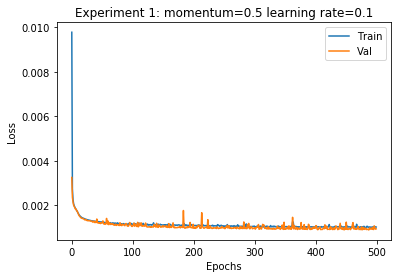

In [26]:
# no regulazation
exp = 1
l = 0.1
m = 0.5
model_lr_1 = Sequential([
        Dense(output_dim=hidden1_num_units,  activation='tanh'),
        Dense(output_dim=hidden2_num_units,  activation='tanh'),
        Dense(output_dim=output_num_units),
 ])
opt = SGD(lr=l, momentum=m)
model_lr_1.compile(loss=vector_mse, optimizer=opt, metrics=[vector_mse,'mse'])
history_1 = model_lr_1.fit(X_train, y_train, epochs=n_ep, batch_size=batch_size, validation_data = (X_val,y_val))

plt.plot(history_1.history['loss'], label = 'train')
plt.plot(history_1.history['val_loss'], label = 'val')
plt.title('Experiment '+str(exp)+': momentum='+str(m)+' learning rate='+str(l))
plt.legend(['Train', 'Val'], loc='upper right')
plt.xlabel('Epochs')
plt.ylabel('Loss')
#plt.savefig('Test '+ str(exp)+'.png',bbox_inches = 'tight',dpi = 600)
plt.show()

# Test 2

/Users/Veronica/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="tanh", units=10)`
  
/Users/Veronica/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="tanh", units=10)`
  import sys
/Users/Veronica/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(units=8)`
  


Train on 832 samples, validate on 209 samples
Epoch 1/500
832/832 [==============================] - 1s 875us/step - loss: 0.0075 - vector_mse: 0.0075 - mean_squared_error: 0.0614 - val_loss: 0.0025 - val_vector_mse: 0.0025 - val_mean_squared_error: 0.0204
Epoch 2/500
832/832 [==============================] - 0s 590us/step - loss: 0.0023 - vector_mse: 0.0023 - mean_squared_error: 0.0191 - val_loss: 0.0022 - val_vector_mse: 0.0022 - val_mean_squared_error: 0.0179
Epoch 3/500
832/832 [==============================] - 1s 605us/step - loss: 0.0021 - vector_mse: 0.0021 - mean_squared_error: 0.0171 - val_loss: 0.0020 - val_vector_mse: 0.0020 - val_mean_squared_error: 0.0167
Epoch 4/500
832/832 [==============================] - 1s 604us/step - loss: 0.0018 - vector_mse: 0.0018 - mean_squared_error: 0.0154 - val_loss: 0.0019 - val_vector_mse: 0.0019 - val_mean_squared_error: 0.0155
Epoch 5/500
832/832 [==============================] - 0s 412us/step - loss: 0.0018 - vector_mse: 0.0018 - mea

Epoch 78/500
832/832 [==============================] - 0s 392us/step - loss: 0.0014 - vector_mse: 0.0014 - mean_squared_error: 0.0123 - val_loss: 0.0029 - val_vector_mse: 0.0029 - val_mean_squared_error: 0.0235
Epoch 79/500
832/832 [==============================] - 0s 426us/step - loss: 0.0025 - vector_mse: 0.0025 - mean_squared_error: 0.0204 - val_loss: 0.0016 - val_vector_mse: 0.0016 - val_mean_squared_error: 0.0138
Epoch 80/500
832/832 [==============================] - 0s 379us/step - loss: 0.0016 - vector_mse: 0.0016 - mean_squared_error: 0.0137 - val_loss: 0.0014 - val_vector_mse: 0.0014 - val_mean_squared_error: 0.0120
Epoch 81/500
832/832 [==============================] - 0s 358us/step - loss: 0.0015 - vector_mse: 0.0015 - mean_squared_error: 0.0130 - val_loss: 0.0014 - val_vector_mse: 0.0014 - val_mean_squared_error: 0.0120
Epoch 82/500
832/832 [==============================] - 0s 381us/step - loss: 0.0015 - vector_mse: 0.0015 - mean_squared_error: 0.0126 - val_loss: 0.001

832/832 [==============================] - 0s 412us/step - loss: 0.0014 - vector_mse: 0.0014 - mean_squared_error: 0.0117 - val_loss: 0.0012 - val_vector_mse: 0.0012 - val_mean_squared_error: 0.0105
Epoch 155/500
832/832 [==============================] - 0s 443us/step - loss: 0.0013 - vector_mse: 0.0013 - mean_squared_error: 0.0109 - val_loss: 0.0015 - val_vector_mse: 0.0015 - val_mean_squared_error: 0.0125
Epoch 156/500
832/832 [==============================] - 0s 429us/step - loss: 0.0012 - vector_mse: 0.0012 - mean_squared_error: 0.0108 - val_loss: 0.0012 - val_vector_mse: 0.0012 - val_mean_squared_error: 0.0099
Epoch 157/500
832/832 [==============================] - 0s 382us/step - loss: 0.0012 - vector_mse: 0.0012 - mean_squared_error: 0.0106 - val_loss: 0.0011 - val_vector_mse: 0.0011 - val_mean_squared_error: 0.0095
Epoch 158/500
832/832 [==============================] - 0s 377us/step - loss: 0.0012 - vector_mse: 0.0012 - mean_squared_error: 0.0104 - val_loss: 0.0011 - val_v

832/832 [==============================] - 0s 361us/step - loss: 0.0012 - vector_mse: 0.0012 - mean_squared_error: 0.0107 - val_loss: 0.0011 - val_vector_mse: 0.0011 - val_mean_squared_error: 0.0092
Epoch 231/500
832/832 [==============================] - 0s 357us/step - loss: 0.0012 - vector_mse: 0.0012 - mean_squared_error: 0.0106 - val_loss: 0.0011 - val_vector_mse: 0.0011 - val_mean_squared_error: 0.0098
Epoch 232/500
832/832 [==============================] - 0s 353us/step - loss: 0.0011 - vector_mse: 0.0011 - mean_squared_error: 0.0099 - val_loss: 9.7518e-04 - val_vector_mse: 9.7518e-04 - val_mean_squared_error: 0.0085
Epoch 233/500
832/832 [==============================] - 0s 372us/step - loss: 0.0016 - vector_mse: 0.0016 - mean_squared_error: 0.0134 - val_loss: 0.0013 - val_vector_mse: 0.0013 - val_mean_squared_error: 0.0108
Epoch 234/500
832/832 [==============================] - 0s 352us/step - loss: 0.0013 - vector_mse: 0.0013 - mean_squared_error: 0.0110 - val_loss: 0.0010

832/832 [==============================] - 0s 418us/step - loss: 0.0012 - vector_mse: 0.0012 - mean_squared_error: 0.0107 - val_loss: 0.0011 - val_vector_mse: 0.0011 - val_mean_squared_error: 0.0093
Epoch 307/500
832/832 [==============================] - 0s 374us/step - loss: 0.0012 - vector_mse: 0.0012 - mean_squared_error: 0.0104 - val_loss: 0.0011 - val_vector_mse: 0.0011 - val_mean_squared_error: 0.0095
Epoch 308/500
832/832 [==============================] - 0s 419us/step - loss: 0.0012 - vector_mse: 0.0012 - mean_squared_error: 0.0105 - val_loss: 0.0011 - val_vector_mse: 0.0011 - val_mean_squared_error: 0.0097
Epoch 309/500
832/832 [==============================] - 0s 364us/step - loss: 0.0014 - vector_mse: 0.0014 - mean_squared_error: 0.0116 - val_loss: 0.0012 - val_vector_mse: 0.0012 - val_mean_squared_error: 0.0105
Epoch 310/500
832/832 [==============================] - 0s 406us/step - loss: 0.0012 - vector_mse: 0.0012 - mean_squared_error: 0.0105 - val_loss: 0.0011 - val_v

832/832 [==============================] - 0s 427us/step - loss: 0.0014 - vector_mse: 0.0014 - mean_squared_error: 0.0118 - val_loss: 0.0012 - val_vector_mse: 0.0012 - val_mean_squared_error: 0.0102
Epoch 383/500
832/832 [==============================] - 0s 363us/step - loss: 0.0013 - vector_mse: 0.0013 - mean_squared_error: 0.0111 - val_loss: 0.0011 - val_vector_mse: 0.0011 - val_mean_squared_error: 0.0097
Epoch 384/500
832/832 [==============================] - 0s 368us/step - loss: 0.0012 - vector_mse: 0.0012 - mean_squared_error: 0.0106 - val_loss: 0.0011 - val_vector_mse: 0.0011 - val_mean_squared_error: 0.0099
Epoch 385/500
832/832 [==============================] - 0s 360us/step - loss: 0.0012 - vector_mse: 0.0012 - mean_squared_error: 0.0107 - val_loss: 0.0011 - val_vector_mse: 0.0011 - val_mean_squared_error: 0.0092
Epoch 386/500
832/832 [==============================] - 0s 480us/step - loss: 0.0012 - vector_mse: 0.0012 - mean_squared_error: 0.0108 - val_loss: 0.0011 - val_v

832/832 [==============================] - 0s 445us/step - loss: 0.0012 - vector_mse: 0.0012 - mean_squared_error: 0.0101 - val_loss: 9.4192e-04 - val_vector_mse: 9.4192e-04 - val_mean_squared_error: 0.0083
Epoch 459/500
832/832 [==============================] - 0s 393us/step - loss: 0.0012 - vector_mse: 0.0012 - mean_squared_error: 0.0104 - val_loss: 0.0011 - val_vector_mse: 0.0011 - val_mean_squared_error: 0.0093
Epoch 460/500
832/832 [==============================] - 0s 421us/step - loss: 0.0012 - vector_mse: 0.0012 - mean_squared_error: 0.0102 - val_loss: 9.8310e-04 - val_vector_mse: 9.8310e-04 - val_mean_squared_error: 0.0086
Epoch 461/500
832/832 [==============================] - 0s 398us/step - loss: 0.0012 - vector_mse: 0.0012 - mean_squared_error: 0.0101 - val_loss: 0.0013 - val_vector_mse: 0.0013 - val_mean_squared_error: 0.0110
Epoch 462/500
832/832 [==============================] - 0s 431us/step - loss: 0.0013 - vector_mse: 0.0013 - mean_squared_error: 0.0113 - val_loss

832/832 [==============================] - 0s 432us/step - loss: 0.0012 - vector_mse: 0.0012 - mean_squared_error: 0.0101 - val_loss: 0.0011 - val_vector_mse: 0.0011 - val_mean_squared_error: 0.0094
Epoch 497/500
832/832 [==============================] - 0s 365us/step - loss: 0.0013 - vector_mse: 0.0013 - mean_squared_error: 0.0113 - val_loss: 0.0014 - val_vector_mse: 0.0014 - val_mean_squared_error: 0.0117
Epoch 498/500
832/832 [==============================] - 0s 381us/step - loss: 0.0014 - vector_mse: 0.0014 - mean_squared_error: 0.0121 - val_loss: 0.0018 - val_vector_mse: 0.0018 - val_mean_squared_error: 0.0154
Epoch 499/500
832/832 [==============================] - 0s 406us/step - loss: 0.0013 - vector_mse: 0.0013 - mean_squared_error: 0.0109 - val_loss: 0.0010 - val_vector_mse: 0.0010 - val_mean_squared_error: 0.0089
Epoch 500/500
832/832 [==============================] - 0s 411us/step - loss: 0.0012 - vector_mse: 0.0012 - mean_squared_error: 0.0103 - val_loss: 9.8150e-04 - v

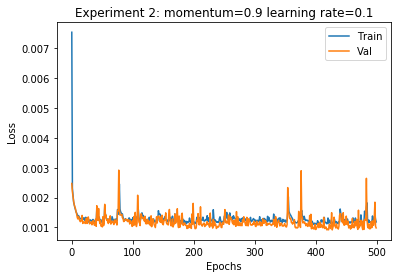

In [27]:
# no regulazation
exp = 2
l = 0.1
m = 0.9
model_lr_2 = Sequential([
        Dense(output_dim=hidden1_num_units,  activation='tanh'),
        Dense(output_dim=hidden2_num_units,  activation='tanh'),
        Dense(output_dim=output_num_units),
 ])
opt = SGD(lr=l, momentum=m)
model_lr_2.compile(loss=vector_mse, optimizer=opt, metrics=[vector_mse,'mse'])
history_2 = model_lr_2.fit(X_train, y_train, epochs=n_ep, batch_size=batch_size, validation_data = (X_val,y_val))
plt.plot(history_2.history['loss'], label = 'train')
plt.plot(history_2.history['val_loss'], label = 'val')
plt.title('Experiment '+str(exp)+': momentum='+str(m)+' learning rate='+str(l))
plt.legend(['Train', 'Val'], loc='upper right')
plt.xlabel('Epochs')
plt.ylabel('Loss')
#plt.savefig('Test '+ str(exp)+'.png',bbox_inches = 'tight',dpi = 600)
plt.show()

# Test 3

/Users/Veronica/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="tanh", units=10)`
  
/Users/Veronica/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="tanh", units=10)`
  import sys
/Users/Veronica/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(units=8)`
  


Train on 832 samples, validate on 209 samples
Epoch 1/500
832/832 [==============================] - 1s 918us/step - loss: 0.0119 - vector_mse: 0.0119 - mean_squared_error: 0.1028 - val_loss: 0.0057 - val_vector_mse: 0.0057 - val_mean_squared_error: 0.0474
Epoch 2/500
832/832 [==============================] - 0s 448us/step - loss: 0.0039 - vector_mse: 0.0039 - mean_squared_error: 0.0329 - val_loss: 0.0039 - val_vector_mse: 0.0039 - val_mean_squared_error: 0.0323
Epoch 3/500
832/832 [==============================] - 0s 359us/step - loss: 0.0029 - vector_mse: 0.0029 - mean_squared_error: 0.0237 - val_loss: 0.0033 - val_vector_mse: 0.0033 - val_mean_squared_error: 0.0269
Epoch 4/500
832/832 [==============================] - 0s 376us/step - loss: 0.0025 - vector_mse: 0.0025 - mean_squared_error: 0.0205 - val_loss: 0.0029 - val_vector_mse: 0.0029 - val_mean_squared_error: 0.0241
Epoch 5/500
832/832 [==============================] - 0s 436us/step - loss: 0.0023 - vector_mse: 0.0023 - mea

Epoch 78/500
832/832 [==============================] - 0s 384us/step - loss: 0.0013 - vector_mse: 0.0013 - mean_squared_error: 0.0108 - val_loss: 0.0013 - val_vector_mse: 0.0013 - val_mean_squared_error: 0.0111
Epoch 79/500
832/832 [==============================] - 0s 372us/step - loss: 0.0013 - vector_mse: 0.0013 - mean_squared_error: 0.0108 - val_loss: 0.0013 - val_vector_mse: 0.0013 - val_mean_squared_error: 0.0111
Epoch 80/500
832/832 [==============================] - 0s 324us/step - loss: 0.0012 - vector_mse: 0.0012 - mean_squared_error: 0.0107 - val_loss: 0.0012 - val_vector_mse: 0.0012 - val_mean_squared_error: 0.0107
Epoch 81/500
832/832 [==============================] - 0s 389us/step - loss: 0.0012 - vector_mse: 0.0012 - mean_squared_error: 0.0107 - val_loss: 0.0013 - val_vector_mse: 0.0013 - val_mean_squared_error: 0.0108
Epoch 82/500
832/832 [==============================] - 0s 381us/step - loss: 0.0012 - vector_mse: 0.0012 - mean_squared_error: 0.0107 - val_loss: 0.001

832/832 [==============================] - 0s 386us/step - loss: 0.0011 - vector_mse: 0.0011 - mean_squared_error: 0.0095 - val_loss: 0.0011 - val_vector_mse: 0.0011 - val_mean_squared_error: 0.0095
Epoch 155/500
832/832 [==============================] - 0s 405us/step - loss: 0.0011 - vector_mse: 0.0011 - mean_squared_error: 0.0096 - val_loss: 0.0010 - val_vector_mse: 0.0010 - val_mean_squared_error: 0.0089
Epoch 156/500
832/832 [==============================] - 0s 397us/step - loss: 0.0011 - vector_mse: 0.0011 - mean_squared_error: 0.0096 - val_loss: 0.0010 - val_vector_mse: 0.0010 - val_mean_squared_error: 0.0091
Epoch 157/500
832/832 [==============================] - 0s 396us/step - loss: 0.0011 - vector_mse: 0.0011 - mean_squared_error: 0.0095 - val_loss: 0.0010 - val_vector_mse: 0.0010 - val_mean_squared_error: 0.0091
Epoch 158/500
832/832 [==============================] - 0s 389us/step - loss: 0.0011 - vector_mse: 0.0011 - mean_squared_error: 0.0095 - val_loss: 0.0010 - val_v

Epoch 230/500
832/832 [==============================] - 0s 406us/step - loss: 0.0011 - vector_mse: 0.0011 - mean_squared_error: 0.0094 - val_loss: 9.9509e-04 - val_vector_mse: 9.9509e-04 - val_mean_squared_error: 0.0087
Epoch 231/500
832/832 [==============================] - 0s 443us/step - loss: 0.0011 - vector_mse: 0.0011 - mean_squared_error: 0.0094 - val_loss: 9.9171e-04 - val_vector_mse: 9.9171e-04 - val_mean_squared_error: 0.0087
Epoch 232/500
832/832 [==============================] - 0s 420us/step - loss: 0.0011 - vector_mse: 0.0011 - mean_squared_error: 0.0094 - val_loss: 9.6968e-04 - val_vector_mse: 9.6968e-04 - val_mean_squared_error: 0.0085
Epoch 233/500
832/832 [==============================] - 0s 419us/step - loss: 0.0011 - vector_mse: 0.0011 - mean_squared_error: 0.0094 - val_loss: 9.9251e-04 - val_vector_mse: 9.9251e-04 - val_mean_squared_error: 0.0087
Epoch 234/500
832/832 [==============================] - 0s 402us/step - loss: 0.0011 - vector_mse: 0.0011 - mean_sq

832/832 [==============================] - 0s 434us/step - loss: 0.0010 - vector_mse: 0.0010 - mean_squared_error: 0.0092 - val_loss: 9.1782e-04 - val_vector_mse: 9.1782e-04 - val_mean_squared_error: 0.0081
Epoch 305/500
832/832 [==============================] - 0s 413us/step - loss: 0.0011 - vector_mse: 0.0011 - mean_squared_error: 0.0095 - val_loss: 9.6683e-04 - val_vector_mse: 9.6683e-04 - val_mean_squared_error: 0.0085
Epoch 306/500
832/832 [==============================] - 0s 424us/step - loss: 0.0010 - vector_mse: 0.0010 - mean_squared_error: 0.0091 - val_loss: 9.3454e-04 - val_vector_mse: 9.3454e-04 - val_mean_squared_error: 0.0082
Epoch 307/500
832/832 [==============================] - 0s 433us/step - loss: 0.0010 - vector_mse: 0.0010 - mean_squared_error: 0.0090 - val_loss: 9.4490e-04 - val_vector_mse: 9.4490e-04 - val_mean_squared_error: 0.0083
Epoch 308/500
832/832 [==============================] - 0s 385us/step - loss: 0.0010 - vector_mse: 0.0010 - mean_squared_error: 0

832/832 [==============================] - 0s 407us/step - loss: 0.0010 - vector_mse: 0.0010 - mean_squared_error: 0.0090 - val_loss: 9.5076e-04 - val_vector_mse: 9.5076e-04 - val_mean_squared_error: 0.0084
Epoch 379/500
832/832 [==============================] - 0s 415us/step - loss: 0.0010 - vector_mse: 0.0010 - mean_squared_error: 0.0091 - val_loss: 8.9667e-04 - val_vector_mse: 8.9667e-04 - val_mean_squared_error: 0.0079
Epoch 380/500
832/832 [==============================] - 0s 365us/step - loss: 0.0010 - vector_mse: 0.0010 - mean_squared_error: 0.0090 - val_loss: 9.4151e-04 - val_vector_mse: 9.4151e-04 - val_mean_squared_error: 0.0083
Epoch 381/500
832/832 [==============================] - 0s 384us/step - loss: 0.0010 - vector_mse: 0.0010 - mean_squared_error: 0.0091 - val_loss: 9.2494e-04 - val_vector_mse: 9.2494e-04 - val_mean_squared_error: 0.0082
Epoch 382/500
832/832 [==============================] - 0s 388us/step - loss: 0.0010 - vector_mse: 0.0010 - mean_squared_error: 0

Epoch 452/500
832/832 [==============================] - 0s 449us/step - loss: 9.9781e-04 - vector_mse: 9.9781e-04 - mean_squared_error: 0.0088 - val_loss: 9.8449e-04 - val_vector_mse: 9.8449e-04 - val_mean_squared_error: 0.0086
Epoch 453/500
832/832 [==============================] - 0s 399us/step - loss: 0.0010 - vector_mse: 0.0010 - mean_squared_error: 0.0089 - val_loss: 8.9858e-04 - val_vector_mse: 8.9858e-04 - val_mean_squared_error: 0.0079
Epoch 454/500
832/832 [==============================] - 0s 419us/step - loss: 0.0010 - vector_mse: 0.0010 - mean_squared_error: 0.0088 - val_loss: 9.3035e-04 - val_vector_mse: 9.3035e-04 - val_mean_squared_error: 0.0082
Epoch 455/500
832/832 [==============================] - 0s 427us/step - loss: 0.0010 - vector_mse: 0.0010 - mean_squared_error: 0.0089 - val_loss: 9.7098e-04 - val_vector_mse: 9.7098e-04 - val_mean_squared_error: 0.0086
Epoch 456/500
832/832 [==============================] - 0s 390us/step - loss: 9.9235e-04 - vector_mse: 9.92

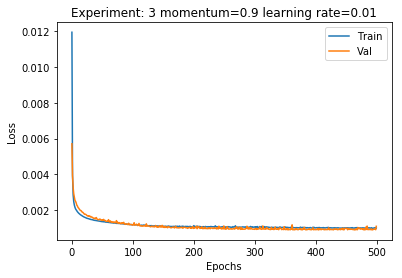

In [28]:
# no regulazation
l = 0.01
m = 0.9
exp = 3
model_lr_3 = Sequential([
        Dense(output_dim=hidden1_num_units,  activation='tanh'),
        Dense(output_dim=hidden2_num_units,  activation='tanh'),
        Dense(output_dim=output_num_units),
 ])
opt = SGD(lr=l, momentum=m)
model_lr_3.compile(loss=vector_mse, optimizer=opt, metrics=[vector_mse,'mse'])
history_3 = model_lr_3.fit(X_train, y_train, epochs=n_ep, batch_size=batch_size, validation_data = (X_val,y_val))
plt.plot(history_3.history['loss'], label = 'train')
plt.plot(history_3.history['val_loss'], label = 'val')
plt.title('Experiment: '+ str(exp)+' momentum='+str(m)+' learning rate='+str(l))
plt.legend(['Train', 'Val'], loc='upper right')
plt.xlabel('Epochs')
plt.ylabel('Loss')
# plt.savefig('Test '+ str(exp)+'.png',bbox_inches = 'tight',dpi = 600)
plt.show()

# Test 4

/Users/Veronica/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="tanh", kernel_regularizer=<keras.reg..., units=10)`
  import sys
/Users/Veronica/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="tanh", kernel_regularizer=<keras.reg..., units=10)`
  
/Users/Veronica/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(units=8)`
  if __name__ == '__main__':


Train on 832 samples, validate on 209 samples
Epoch 1/500
832/832 [==============================] - 1s 1ms/step - loss: 0.0178 - vector_mse: 0.0169 - mean_squared_error: 0.1292 - val_loss: 0.0059 - val_vector_mse: 0.0049 - val_mean_squared_error: 0.0396
Epoch 2/500
832/832 [==============================] - 1s 808us/step - loss: 0.0046 - vector_mse: 0.0037 - mean_squared_error: 0.0301 - val_loss: 0.0041 - val_vector_mse: 0.0031 - val_mean_squared_error: 0.0256
Epoch 3/500
832/832 [==============================] - 0s 502us/step - loss: 0.0037 - vector_mse: 0.0027 - mean_squared_error: 0.0225 - val_loss: 0.0035 - val_vector_mse: 0.0026 - val_mean_squared_error: 0.0215
Epoch 4/500
832/832 [==============================] - 1s 636us/step - loss: 0.0033 - vector_mse: 0.0024 - mean_squared_error: 0.0198 - val_loss: 0.0033 - val_vector_mse: 0.0024 - val_mean_squared_error: 0.0198
Epoch 5/500
832/832 [==============================] - 0s 579us/step - loss: 0.0032 - vector_mse: 0.0022 - mean_

Epoch 78/500
832/832 [==============================] - 0s 345us/step - loss: 0.0019 - vector_mse: 0.0012 - mean_squared_error: 0.0107 - val_loss: 0.0019 - val_vector_mse: 0.0012 - val_mean_squared_error: 0.0105
Epoch 79/500
832/832 [==============================] - 0s 339us/step - loss: 0.0019 - vector_mse: 0.0012 - mean_squared_error: 0.0107 - val_loss: 0.0019 - val_vector_mse: 0.0012 - val_mean_squared_error: 0.0104
Epoch 80/500
832/832 [==============================] - 0s 365us/step - loss: 0.0019 - vector_mse: 0.0012 - mean_squared_error: 0.0107 - val_loss: 0.0019 - val_vector_mse: 0.0012 - val_mean_squared_error: 0.0104
Epoch 81/500
832/832 [==============================] - 0s 345us/step - loss: 0.0019 - vector_mse: 0.0012 - mean_squared_error: 0.0106 - val_loss: 0.0019 - val_vector_mse: 0.0012 - val_mean_squared_error: 0.0104
Epoch 82/500
832/832 [==============================] - 0s 362us/step - loss: 0.0019 - vector_mse: 0.0012 - mean_squared_error: 0.0106 - val_loss: 0.001

832/832 [==============================] - 0s 395us/step - loss: 0.0015 - vector_mse: 0.0011 - mean_squared_error: 0.0094 - val_loss: 0.0015 - val_vector_mse: 9.8989e-04 - val_mean_squared_error: 0.0087
Epoch 155/500
832/832 [==============================] - 0s 409us/step - loss: 0.0015 - vector_mse: 0.0011 - mean_squared_error: 0.0094 - val_loss: 0.0014 - val_vector_mse: 9.8075e-04 - val_mean_squared_error: 0.0086
Epoch 156/500
832/832 [==============================] - 0s 446us/step - loss: 0.0015 - vector_mse: 0.0011 - mean_squared_error: 0.0094 - val_loss: 0.0014 - val_vector_mse: 9.7494e-04 - val_mean_squared_error: 0.0086
Epoch 157/500
832/832 [==============================] - 0s 370us/step - loss: 0.0015 - vector_mse: 0.0011 - mean_squared_error: 0.0094 - val_loss: 0.0015 - val_vector_mse: 9.9188e-04 - val_mean_squared_error: 0.0087
Epoch 158/500
832/832 [==============================] - 0s 394us/step - loss: 0.0015 - vector_mse: 0.0011 - mean_squared_error: 0.0094 - val_loss

Epoch 229/500
832/832 [==============================] - 0s 388us/step - loss: 0.0014 - vector_mse: 0.0010 - mean_squared_error: 0.0090 - val_loss: 0.0013 - val_vector_mse: 9.1274e-04 - val_mean_squared_error: 0.0081
Epoch 230/500
832/832 [==============================] - 0s 377us/step - loss: 0.0014 - vector_mse: 0.0010 - mean_squared_error: 0.0091 - val_loss: 0.0012 - val_vector_mse: 9.0664e-04 - val_mean_squared_error: 0.0080
Epoch 231/500
832/832 [==============================] - 0s 389us/step - loss: 0.0014 - vector_mse: 0.0010 - mean_squared_error: 0.0090 - val_loss: 0.0013 - val_vector_mse: 9.2596e-04 - val_mean_squared_error: 0.0082
Epoch 232/500
832/832 [==============================] - 0s 394us/step - loss: 0.0014 - vector_mse: 0.0010 - mean_squared_error: 0.0090 - val_loss: 0.0013 - val_vector_mse: 9.1177e-04 - val_mean_squared_error: 0.0081
Epoch 233/500
832/832 [==============================] - 0s 385us/step - loss: 0.0013 - vector_mse: 0.0010 - mean_squared_error: 0.0

Epoch 267/500
832/832 [==============================] - 0s 371us/step - loss: 0.0013 - vector_mse: 0.0010 - mean_squared_error: 0.0089 - val_loss: 0.0012 - val_vector_mse: 8.9271e-04 - val_mean_squared_error: 0.0079
Epoch 268/500
832/832 [==============================] - 0s 443us/step - loss: 0.0013 - vector_mse: 0.0010 - mean_squared_error: 0.0089 - val_loss: 0.0012 - val_vector_mse: 9.0237e-04 - val_mean_squared_error: 0.0080
Epoch 269/500
832/832 [==============================] - 0s 405us/step - loss: 0.0013 - vector_mse: 0.0010 - mean_squared_error: 0.0089 - val_loss: 0.0012 - val_vector_mse: 9.3674e-04 - val_mean_squared_error: 0.0083
Epoch 270/500
832/832 [==============================] - 0s 440us/step - loss: 0.0013 - vector_mse: 0.0010 - mean_squared_error: 0.0089 - val_loss: 0.0013 - val_vector_mse: 0.0010 - val_mean_squared_error: 0.0089
Epoch 271/500
832/832 [==============================] - 0s 418us/step - loss: 0.0013 - vector_mse: 0.0010 - mean_squared_error: 0.0089 

Epoch 305/500
832/832 [==============================] - 0s 386us/step - loss: 0.0013 - vector_mse: 9.9807e-04 - mean_squared_error: 0.0088 - val_loss: 0.0011 - val_vector_mse: 8.8174e-04 - val_mean_squared_error: 0.0078
Epoch 306/500
832/832 [==============================] - 0s 397us/step - loss: 0.0013 - vector_mse: 9.9741e-04 - mean_squared_error: 0.0088 - val_loss: 0.0012 - val_vector_mse: 9.7559e-04 - val_mean_squared_error: 0.0086
Epoch 307/500
832/832 [==============================] - 0s 354us/step - loss: 0.0013 - vector_mse: 9.9516e-04 - mean_squared_error: 0.0088 - val_loss: 0.0011 - val_vector_mse: 8.8261e-04 - val_mean_squared_error: 0.0078
Epoch 308/500
832/832 [==============================] - 0s 368us/step - loss: 0.0013 - vector_mse: 0.0010 - mean_squared_error: 0.0089 - val_loss: 0.0012 - val_vector_mse: 9.0486e-04 - val_mean_squared_error: 0.0080
Epoch 309/500
832/832 [==============================] - 0s 421us/step - loss: 0.0013 - vector_mse: 0.0010 - mean_square

832/832 [==============================] - 0s 382us/step - loss: 0.0012 - vector_mse: 0.0010 - mean_squared_error: 0.0089 - val_loss: 0.0011 - val_vector_mse: 9.0156e-04 - val_mean_squared_error: 0.0080
Epoch 380/500
832/832 [==============================] - 0s 376us/step - loss: 0.0012 - vector_mse: 9.9340e-04 - mean_squared_error: 0.0088 - val_loss: 0.0011 - val_vector_mse: 9.0992e-04 - val_mean_squared_error: 0.0080
Epoch 381/500
832/832 [==============================] - 0s 389us/step - loss: 0.0012 - vector_mse: 9.9175e-04 - mean_squared_error: 0.0088 - val_loss: 0.0011 - val_vector_mse: 8.8419e-04 - val_mean_squared_error: 0.0078
Epoch 382/500
832/832 [==============================] - 1s 645us/step - loss: 0.0012 - vector_mse: 9.9185e-04 - mean_squared_error: 0.0088 - val_loss: 0.0011 - val_vector_mse: 9.0227e-04 - val_mean_squared_error: 0.0080
Epoch 383/500
832/832 [==============================] - 1s 613us/step - loss: 0.0012 - vector_mse: 9.9121e-04 - mean_squared_error: 0

832/832 [==============================] - 0s 442us/step - loss: 0.0011 - vector_mse: 9.8824e-04 - mean_squared_error: 0.0087 - val_loss: 0.0010 - val_vector_mse: 8.6892e-04 - val_mean_squared_error: 0.0077
Epoch 454/500
832/832 [==============================] - 0s 398us/step - loss: 0.0011 - vector_mse: 9.8859e-04 - mean_squared_error: 0.0088 - val_loss: 0.0010 - val_vector_mse: 8.8551e-04 - val_mean_squared_error: 0.0079
Epoch 455/500
832/832 [==============================] - 0s 491us/step - loss: 0.0011 - vector_mse: 9.8882e-04 - mean_squared_error: 0.0087 - val_loss: 0.0011 - val_vector_mse: 9.7896e-04 - val_mean_squared_error: 0.0086
Epoch 456/500
832/832 [==============================] - 0s 446us/step - loss: 0.0011 - vector_mse: 9.8905e-04 - mean_squared_error: 0.0087 - val_loss: 0.0010 - val_vector_mse: 8.7105e-04 - val_mean_squared_error: 0.0077
Epoch 457/500
832/832 [==============================] - 0s 414us/step - loss: 0.0011 - vector_mse: 9.8448e-04 - mean_squared_erro

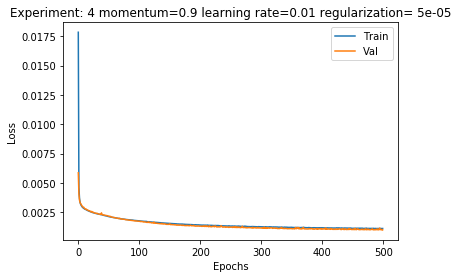

In [30]:
# regulazation
exp = 4
l = 0.01
m = 0.9
r = 0.00005
model_lr_4 = Sequential([
        Dense(output_dim=hidden1_num_units,  activation='tanh', kernel_regularizer=regularizers.l2(r)),
        Dense(output_dim=hidden2_num_units,  activation='tanh', kernel_regularizer=regularizers.l2(r)),
        Dense(output_dim=output_num_units),
 ])
opt = SGD(lr=l, momentum=m)
model_lr_4.compile(loss=vector_mse, optimizer=opt, metrics=[vector_mse,'mse'])
history_4 = model_lr_4.fit(X_train, y_train, epochs=n_ep, batch_size=batch_size, validation_data = (X_val,y_val))
plt.plot(history_4.history['loss'], label = 'train')
plt.plot(history_4.history['val_loss'], label = 'val')
plt.title('Experiment: '+ str(exp)+' momentum='+str(m)+' learning rate='+str(l) + ' regularization= '+str(r))
plt.legend(['Train', 'Val'], loc='upper right')
plt.xlabel('Epochs')
plt.ylabel('Loss')
#plt.savefig('Test '+ str(exp)+'.png',bbox_inches = 'tight',dpi = 600)
plt.show()

# Test 5

/Users/Veronica/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="tanh", kernel_regularizer=<keras.reg..., units=10)`
  import sys
/Users/Veronica/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="tanh", kernel_regularizer=<keras.reg..., units=10)`
  
/Users/Veronica/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(units=8)`
  if __name__ == '__main__':


Train on 832 samples, validate on 209 samples
Epoch 1/500
832/832 [==============================] - 1s 858us/step - loss: 0.0221 - vector_mse: 0.0129 - mean_squared_error: 0.1096 - val_loss: 0.0140 - val_vector_mse: 0.0052 - val_mean_squared_error: 0.0428
Epoch 2/500
832/832 [==============================] - 0s 420us/step - loss: 0.0127 - vector_mse: 0.0041 - mean_squared_error: 0.0339 - val_loss: 0.0119 - val_vector_mse: 0.0035 - val_mean_squared_error: 0.0286
Epoch 3/500
832/832 [==============================] - 0s 422us/step - loss: 0.0112 - vector_mse: 0.0030 - mean_squared_error: 0.0245 - val_loss: 0.0109 - val_vector_mse: 0.0028 - val_mean_squared_error: 0.0232
Epoch 4/500
832/832 [==============================] - 0s 395us/step - loss: 0.0104 - vector_mse: 0.0025 - mean_squared_error: 0.0208 - val_loss: 0.0103 - val_vector_mse: 0.0026 - val_mean_squared_error: 0.0212
Epoch 5/500
832/832 [==============================] - 0s 496us/step - loss: 0.0098 - vector_mse: 0.0023 - mea

Epoch 78/500
832/832 [==============================] - 0s 377us/step - loss: 0.0015 - vector_mse: 0.0011 - mean_squared_error: 0.0095 - val_loss: 0.0014 - val_vector_mse: 9.9969e-04 - val_mean_squared_error: 0.0088
Epoch 79/500
832/832 [==============================] - 0s 378us/step - loss: 0.0015 - vector_mse: 0.0011 - mean_squared_error: 0.0095 - val_loss: 0.0014 - val_vector_mse: 9.9520e-04 - val_mean_squared_error: 0.0087
Epoch 80/500
832/832 [==============================] - 0s 394us/step - loss: 0.0015 - vector_mse: 0.0011 - mean_squared_error: 0.0094 - val_loss: 0.0014 - val_vector_mse: 9.9252e-04 - val_mean_squared_error: 0.0087
Epoch 81/500
832/832 [==============================] - 0s 418us/step - loss: 0.0015 - vector_mse: 0.0011 - mean_squared_error: 0.0094 - val_loss: 0.0014 - val_vector_mse: 0.0010 - val_mean_squared_error: 0.0089
Epoch 82/500
832/832 [==============================] - 0s 417us/step - loss: 0.0015 - vector_mse: 0.0011 - mean_squared_error: 0.0095 - val

Epoch 116/500
832/832 [==============================] - 0s 414us/step - loss: 0.0012 - vector_mse: 0.0010 - mean_squared_error: 0.0092 - val_loss: 0.0011 - val_vector_mse: 9.5603e-04 - val_mean_squared_error: 0.0084
Epoch 117/500
832/832 [==============================] - 0s 439us/step - loss: 0.0012 - vector_mse: 0.0010 - mean_squared_error: 0.0092 - val_loss: 0.0011 - val_vector_mse: 9.9267e-04 - val_mean_squared_error: 0.0087
Epoch 118/500
832/832 [==============================] - 0s 454us/step - loss: 0.0012 - vector_mse: 0.0010 - mean_squared_error: 0.0092 - val_loss: 0.0012 - val_vector_mse: 0.0010 - val_mean_squared_error: 0.0089
Epoch 119/500
832/832 [==============================] - 0s 380us/step - loss: 0.0012 - vector_mse: 0.0010 - mean_squared_error: 0.0092 - val_loss: 0.0011 - val_vector_mse: 9.5037e-04 - val_mean_squared_error: 0.0084
Epoch 120/500
832/832 [==============================] - 0s 395us/step - loss: 0.0012 - vector_mse: 0.0010 - mean_squared_error: 0.0092 

Epoch 154/500
832/832 [==============================] - 0s 427us/step - loss: 0.0011 - vector_mse: 0.0010 - mean_squared_error: 0.0091 - val_loss: 0.0010 - val_vector_mse: 9.3691e-04 - val_mean_squared_error: 0.0083
Epoch 155/500
832/832 [==============================] - 0s 417us/step - loss: 0.0011 - vector_mse: 0.0010 - mean_squared_error: 0.0091 - val_loss: 0.0010 - val_vector_mse: 9.3592e-04 - val_mean_squared_error: 0.0082
Epoch 156/500
832/832 [==============================] - 0s 448us/step - loss: 0.0011 - vector_mse: 0.0010 - mean_squared_error: 0.0091 - val_loss: 0.0010 - val_vector_mse: 9.4144e-04 - val_mean_squared_error: 0.0083
Epoch 157/500
832/832 [==============================] - 0s 454us/step - loss: 0.0011 - vector_mse: 0.0010 - mean_squared_error: 0.0091 - val_loss: 0.0010 - val_vector_mse: 9.4746e-04 - val_mean_squared_error: 0.0084
Epoch 158/500
832/832 [==============================] - 0s 416us/step - loss: 0.0011 - vector_mse: 0.0010 - mean_squared_error: 0.0

Epoch 192/500
832/832 [==============================] - 0s 393us/step - loss: 0.0011 - vector_mse: 0.0010 - mean_squared_error: 0.0091 - val_loss: 0.0010 - val_vector_mse: 9.4248e-04 - val_mean_squared_error: 0.0083
Epoch 193/500
832/832 [==============================] - 0s 376us/step - loss: 0.0011 - vector_mse: 0.0010 - mean_squared_error: 0.0091 - val_loss: 0.0010 - val_vector_mse: 9.4195e-04 - val_mean_squared_error: 0.0083
Epoch 194/500
832/832 [==============================] - 0s 391us/step - loss: 0.0011 - vector_mse: 0.0010 - mean_squared_error: 0.0090 - val_loss: 0.0010 - val_vector_mse: 9.7410e-04 - val_mean_squared_error: 0.0086
Epoch 195/500
832/832 [==============================] - 0s 398us/step - loss: 0.0011 - vector_mse: 0.0010 - mean_squared_error: 0.0091 - val_loss: 0.0010 - val_vector_mse: 9.4666e-04 - val_mean_squared_error: 0.0084
Epoch 196/500
832/832 [==============================] - 0s 378us/step - loss: 0.0011 - vector_mse: 0.0010 - mean_squared_error: 0.0

832/832 [==============================] - 0s 448us/step - loss: 0.0011 - vector_mse: 0.0010 - mean_squared_error: 0.0090 - val_loss: 9.8422e-04 - val_vector_mse: 9.2205e-04 - val_mean_squared_error: 0.0081
Epoch 267/500
832/832 [==============================] - 0s 409us/step - loss: 0.0011 - vector_mse: 0.0010 - mean_squared_error: 0.0091 - val_loss: 9.8783e-04 - val_vector_mse: 9.2605e-04 - val_mean_squared_error: 0.0082
Epoch 268/500
832/832 [==============================] - 0s 418us/step - loss: 0.0011 - vector_mse: 0.0010 - mean_squared_error: 0.0091 - val_loss: 0.0010 - val_vector_mse: 9.5488e-04 - val_mean_squared_error: 0.0084
Epoch 269/500
832/832 [==============================] - 0s 388us/step - loss: 0.0011 - vector_mse: 0.0010 - mean_squared_error: 0.0091 - val_loss: 0.0010 - val_vector_mse: 9.4466e-04 - val_mean_squared_error: 0.0083
Epoch 270/500
832/832 [==============================] - 0s 379us/step - loss: 0.0011 - vector_mse: 0.0010 - mean_squared_error: 0.0091 - 

832/832 [==============================] - 0s 437us/step - loss: 0.0011 - vector_mse: 0.0010 - mean_squared_error: 0.0090 - val_loss: 9.7266e-04 - val_vector_mse: 9.1649e-04 - val_mean_squared_error: 0.0081
Epoch 341/500
832/832 [==============================] - 0s 397us/step - loss: 0.0011 - vector_mse: 0.0010 - mean_squared_error: 0.0090 - val_loss: 9.8994e-04 - val_vector_mse: 9.3435e-04 - val_mean_squared_error: 0.0083
Epoch 342/500
832/832 [==============================] - 0s 402us/step - loss: 0.0011 - vector_mse: 0.0010 - mean_squared_error: 0.0090 - val_loss: 9.8638e-04 - val_vector_mse: 9.3066e-04 - val_mean_squared_error: 0.0082
Epoch 343/500
832/832 [==============================] - 0s 474us/step - loss: 0.0011 - vector_mse: 0.0010 - mean_squared_error: 0.0090 - val_loss: 9.7054e-04 - val_vector_mse: 9.1414e-04 - val_mean_squared_error: 0.0081
Epoch 344/500
832/832 [==============================] - 0s 402us/step - loss: 0.0011 - vector_mse: 0.0010 - mean_squared_error: 0

Epoch 377/500
832/832 [==============================] - 0s 432us/step - loss: 0.0011 - vector_mse: 0.0010 - mean_squared_error: 0.0090 - val_loss: 9.8349e-04 - val_vector_mse: 9.2966e-04 - val_mean_squared_error: 0.0082
Epoch 378/500
832/832 [==============================] - 0s 423us/step - loss: 0.0011 - vector_mse: 0.0010 - mean_squared_error: 0.0090 - val_loss: 9.9927e-04 - val_vector_mse: 9.4586e-04 - val_mean_squared_error: 0.0084
Epoch 379/500
832/832 [==============================] - 0s 385us/step - loss: 0.0011 - vector_mse: 0.0010 - mean_squared_error: 0.0090 - val_loss: 9.6608e-04 - val_vector_mse: 9.1213e-04 - val_mean_squared_error: 0.0081
Epoch 380/500
832/832 [==============================] - 0s 426us/step - loss: 0.0011 - vector_mse: 0.0010 - mean_squared_error: 0.0090 - val_loss: 9.7991e-04 - val_vector_mse: 9.2669e-04 - val_mean_squared_error: 0.0082
Epoch 381/500
832/832 [==============================] - 0s 384us/step - loss: 0.0011 - vector_mse: 0.0010 - mean_sq

832/832 [==============================] - 0s 445us/step - loss: 0.0011 - vector_mse: 0.0010 - mean_squared_error: 0.0090 - val_loss: 9.5816e-04 - val_vector_mse: 9.0767e-04 - val_mean_squared_error: 0.0080
Epoch 452/500
832/832 [==============================] - 0s 395us/step - loss: 0.0011 - vector_mse: 0.0010 - mean_squared_error: 0.0090 - val_loss: 0.0010 - val_vector_mse: 9.5278e-04 - val_mean_squared_error: 0.0084
Epoch 453/500
832/832 [==============================] - 0s 406us/step - loss: 0.0011 - vector_mse: 0.0010 - mean_squared_error: 0.0090 - val_loss: 9.7460e-04 - val_vector_mse: 9.2494e-04 - val_mean_squared_error: 0.0082
Epoch 454/500
832/832 [==============================] - 0s 384us/step - loss: 0.0011 - vector_mse: 0.0010 - mean_squared_error: 0.0090 - val_loss: 9.5980e-04 - val_vector_mse: 9.0979e-04 - val_mean_squared_error: 0.0081
Epoch 455/500
832/832 [==============================] - 0s 419us/step - loss: 0.0011 - vector_mse: 0.0010 - mean_squared_error: 0.009

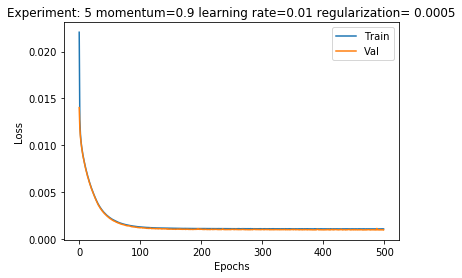

In [31]:
# regularization
exp = 5
l = 0.01
m = 0.9
r = 0.0005
model_lr_5 = Sequential([
        Dense(output_dim=hidden1_num_units,  activation='tanh', kernel_regularizer=regularizers.l2(r)),
        Dense(output_dim=hidden2_num_units,  activation='tanh', kernel_regularizer=regularizers.l2(r)),
        Dense(output_dim=output_num_units),
 ])
opt = SGD(lr=l, momentum=m)
model_lr_5.compile(loss=vector_mse, optimizer=opt, metrics=[vector_mse,'mse'])
history_5 = model_lr_5.fit(X_train, y_train, epochs=n_ep, batch_size=batch_size, validation_data = (X_val,y_val))
plt.plot(history_5.history['loss'], label = 'train')
plt.plot(history_5.history['val_loss'], label = 'val')
plt.title('Experiment: '+ str(exp)+' momentum='+str(m)+' learning rate='+str(l) + ' regularization= '+str(r))
plt.legend(['Train', 'Val'], loc='upper right')
plt.xlabel('Epochs')
plt.ylabel('Loss')
#plt.savefig('Test '+ str(exp)+'.png',bbox_inches = 'tight',dpi = 600)
plt.show()

# Test 6

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


/Users/Veronica/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="tanh", kernel_regularizer=<keras.reg..., units=10)`
  
/Users/Veronica/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="tanh", kernel_regularizer=<keras.reg..., units=10)`
  # Remove the CWD from sys.path while we load stuff.
/Users/Veronica/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(units=8)`
  if sys.path[0] == '':


Train on 832 samples, validate on 209 samples
Epoch 1/500
832/832 [==============================] - 1s 1ms/step - loss: 0.0505 - vector_mse: 0.0410 - mean_squared_error: 0.3381 - val_loss: 0.0150 - val_vector_mse: 0.0061 - val_mean_squared_error: 0.0508
Epoch 2/500
832/832 [==============================] - 0s 508us/step - loss: 0.0264 - vector_mse: 0.0179 - mean_squared_error: 0.1470 - val_loss: 0.0116 - val_vector_mse: 0.0035 - val_mean_squared_error: 0.0285
Epoch 3/500
832/832 [==============================] - 1s 620us/step - loss: 0.0196 - vector_mse: 0.0119 - mean_squared_error: 0.0979 - val_loss: 0.0101 - val_vector_mse: 0.0026 - val_mean_squared_error: 0.0216
Epoch 4/500
832/832 [==============================] - 0s 510us/step - loss: 0.0155 - vector_mse: 0.0082 - mean_squared_error: 0.0682 - val_loss: 0.0094 - val_vector_mse: 0.0024 - val_mean_squared_error: 0.0203
Epoch 5/500
832/832 [==============================] - 0s 546us/step - loss: 0.0134 - vector_mse: 0.0066 - mean_

Epoch 78/500
832/832 [==============================] - 0s 553us/step - loss: 0.0017 - vector_mse: 0.0014 - mean_squared_error: 0.0120 - val_loss: 0.0014 - val_vector_mse: 0.0011 - val_mean_squared_error: 0.0093
Epoch 79/500
832/832 [==============================] - 0s 522us/step - loss: 0.0018 - vector_mse: 0.0015 - mean_squared_error: 0.0126 - val_loss: 0.0014 - val_vector_mse: 0.0011 - val_mean_squared_error: 0.0094
Epoch 80/500
832/832 [==============================] - 0s 564us/step - loss: 0.0017 - vector_mse: 0.0014 - mean_squared_error: 0.0124 - val_loss: 0.0014 - val_vector_mse: 0.0011 - val_mean_squared_error: 0.0097
Epoch 81/500
832/832 [==============================] - 0s 523us/step - loss: 0.0017 - vector_mse: 0.0014 - mean_squared_error: 0.0123 - val_loss: 0.0013 - val_vector_mse: 0.0011 - val_mean_squared_error: 0.0094
Epoch 82/500
832/832 [==============================] - 0s 586us/step - loss: 0.0017 - vector_mse: 0.0014 - mean_squared_error: 0.0121 - val_loss: 0.001

832/832 [==============================] - 1s 683us/step - loss: 0.0014 - vector_mse: 0.0013 - mean_squared_error: 0.0113 - val_loss: 0.0011 - val_vector_mse: 0.0010 - val_mean_squared_error: 0.0089
Epoch 155/500
832/832 [==============================] - 1s 719us/step - loss: 0.0013 - vector_mse: 0.0013 - mean_squared_error: 0.0110 - val_loss: 0.0011 - val_vector_mse: 0.0010 - val_mean_squared_error: 0.0088
Epoch 156/500
832/832 [==============================] - 1s 952us/step - loss: 0.0013 - vector_mse: 0.0013 - mean_squared_error: 0.0109 - val_loss: 0.0011 - val_vector_mse: 9.9764e-04 - val_mean_squared_error: 0.0088
Epoch 157/500
832/832 [==============================] - 1s 1ms/step - loss: 0.0013 - vector_mse: 0.0012 - mean_squared_error: 0.0107 - val_loss: 0.0012 - val_vector_mse: 0.0011 - val_mean_squared_error: 0.0095
Epoch 158/500
832/832 [==============================] - 1s 1ms/step - loss: 0.0014 - vector_mse: 0.0013 - mean_squared_error: 0.0112 - val_loss: 0.0010 - val_v

832/832 [==============================] - 0s 566us/step - loss: 0.0014 - vector_mse: 0.0013 - mean_squared_error: 0.0115 - val_loss: 0.0011 - val_vector_mse: 0.0010 - val_mean_squared_error: 0.0088
Epoch 231/500
832/832 [==============================] - 0s 546us/step - loss: 0.0013 - vector_mse: 0.0012 - mean_squared_error: 0.0106 - val_loss: 0.0010 - val_vector_mse: 9.7611e-04 - val_mean_squared_error: 0.0086
Epoch 232/500
832/832 [==============================] - 0s 516us/step - loss: 0.0014 - vector_mse: 0.0013 - mean_squared_error: 0.0114 - val_loss: 0.0010 - val_vector_mse: 9.6536e-04 - val_mean_squared_error: 0.0085
Epoch 233/500
832/832 [==============================] - 1s 657us/step - loss: 0.0013 - vector_mse: 0.0013 - mean_squared_error: 0.0110 - val_loss: 0.0010 - val_vector_mse: 9.6031e-04 - val_mean_squared_error: 0.0084
Epoch 234/500
832/832 [==============================] - 0s 585us/step - loss: 0.0014 - vector_mse: 0.0013 - mean_squared_error: 0.0115 - val_loss: 0.

832/832 [==============================] - 0s 525us/step - loss: 0.0013 - vector_mse: 0.0013 - mean_squared_error: 0.0109 - val_loss: 0.0011 - val_vector_mse: 0.0010 - val_mean_squared_error: 0.0091
Epoch 307/500
832/832 [==============================] - 0s 540us/step - loss: 0.0013 - vector_mse: 0.0013 - mean_squared_error: 0.0110 - val_loss: 0.0010 - val_vector_mse: 9.7970e-04 - val_mean_squared_error: 0.0086
Epoch 308/500
832/832 [==============================] - 0s 530us/step - loss: 0.0014 - vector_mse: 0.0013 - mean_squared_error: 0.0114 - val_loss: 0.0011 - val_vector_mse: 0.0010 - val_mean_squared_error: 0.0090
Epoch 309/500
832/832 [==============================] - 0s 524us/step - loss: 0.0013 - vector_mse: 0.0012 - mean_squared_error: 0.0106 - val_loss: 0.0010 - val_vector_mse: 9.6355e-04 - val_mean_squared_error: 0.0085
Epoch 310/500
832/832 [==============================] - 0s 544us/step - loss: 0.0013 - vector_mse: 0.0013 - mean_squared_error: 0.0111 - val_loss: 0.0010

Epoch 344/500
832/832 [==============================] - 0s 586us/step - loss: 0.0013 - vector_mse: 0.0012 - mean_squared_error: 0.0108 - val_loss: 0.0010 - val_vector_mse: 9.6919e-04 - val_mean_squared_error: 0.0085
Epoch 345/500
832/832 [==============================] - 1s 616us/step - loss: 0.0013 - vector_mse: 0.0012 - mean_squared_error: 0.0108 - val_loss: 9.8653e-04 - val_vector_mse: 9.3959e-04 - val_mean_squared_error: 0.0083
Epoch 346/500
832/832 [==============================] - 0s 549us/step - loss: 0.0013 - vector_mse: 0.0013 - mean_squared_error: 0.0110 - val_loss: 0.0012 - val_vector_mse: 0.0011 - val_mean_squared_error: 0.0099
Epoch 347/500
832/832 [==============================] - 0s 549us/step - loss: 0.0014 - vector_mse: 0.0013 - mean_squared_error: 0.0113 - val_loss: 0.0010 - val_vector_mse: 9.8489e-04 - val_mean_squared_error: 0.0087
Epoch 348/500
832/832 [==============================] - 0s 516us/step - loss: 0.0013 - vector_mse: 0.0013 - mean_squared_error: 0.0

Epoch 382/500
832/832 [==============================] - 0s 553us/step - loss: 0.0013 - vector_mse: 0.0012 - mean_squared_error: 0.0107 - val_loss: 9.8868e-04 - val_vector_mse: 9.4443e-04 - val_mean_squared_error: 0.0083
Epoch 383/500
832/832 [==============================] - 0s 502us/step - loss: 0.0014 - vector_mse: 0.0013 - mean_squared_error: 0.0113 - val_loss: 0.0011 - val_vector_mse: 0.0011 - val_mean_squared_error: 0.0092
Epoch 384/500
832/832 [==============================] - 0s 544us/step - loss: 0.0013 - vector_mse: 0.0012 - mean_squared_error: 0.0106 - val_loss: 9.8639e-04 - val_vector_mse: 9.4274e-04 - val_mean_squared_error: 0.0083
Epoch 385/500
832/832 [==============================] - 0s 513us/step - loss: 0.0014 - vector_mse: 0.0014 - mean_squared_error: 0.0118 - val_loss: 0.0010 - val_vector_mse: 9.7005e-04 - val_mean_squared_error: 0.0085
Epoch 386/500
832/832 [==============================] - 0s 542us/step - loss: 0.0013 - vector_mse: 0.0013 - mean_squared_error:

Epoch 420/500
832/832 [==============================] - 0s 525us/step - loss: 0.0013 - vector_mse: 0.0012 - mean_squared_error: 0.0107 - val_loss: 0.0010 - val_vector_mse: 9.9954e-04 - val_mean_squared_error: 0.0088
Epoch 421/500
832/832 [==============================] - 0s 588us/step - loss: 0.0013 - vector_mse: 0.0013 - mean_squared_error: 0.0109 - val_loss: 0.0010 - val_vector_mse: 9.6126e-04 - val_mean_squared_error: 0.0085
Epoch 422/500
832/832 [==============================] - 0s 574us/step - loss: 0.0014 - vector_mse: 0.0013 - mean_squared_error: 0.0114 - val_loss: 0.0010 - val_vector_mse: 9.7090e-04 - val_mean_squared_error: 0.0086
Epoch 423/500
832/832 [==============================] - 0s 580us/step - loss: 0.0014 - vector_mse: 0.0013 - mean_squared_error: 0.0115 - val_loss: 9.9752e-04 - val_vector_mse: 9.5435e-04 - val_mean_squared_error: 0.0084
Epoch 424/500
832/832 [==============================] - 0s 527us/step - loss: 0.0013 - vector_mse: 0.0013 - mean_squared_error:

Epoch 458/500
832/832 [==============================] - 0s 591us/step - loss: 0.0012 - vector_mse: 0.0012 - mean_squared_error: 0.0104 - val_loss: 0.0010 - val_vector_mse: 9.8157e-04 - val_mean_squared_error: 0.0086
Epoch 459/500
832/832 [==============================] - 0s 570us/step - loss: 0.0013 - vector_mse: 0.0013 - mean_squared_error: 0.0112 - val_loss: 0.0010 - val_vector_mse: 9.9285e-04 - val_mean_squared_error: 0.0087
Epoch 460/500
832/832 [==============================] - 0s 525us/step - loss: 0.0013 - vector_mse: 0.0013 - mean_squared_error: 0.0111 - val_loss: 0.0010 - val_vector_mse: 9.7471e-04 - val_mean_squared_error: 0.0086
Epoch 461/500
832/832 [==============================] - 0s 568us/step - loss: 0.0013 - vector_mse: 0.0013 - mean_squared_error: 0.0109 - val_loss: 9.9285e-04 - val_vector_mse: 9.5116e-04 - val_mean_squared_error: 0.0084
Epoch 462/500
832/832 [==============================] - 0s 561us/step - loss: 0.0013 - vector_mse: 0.0012 - mean_squared_error:

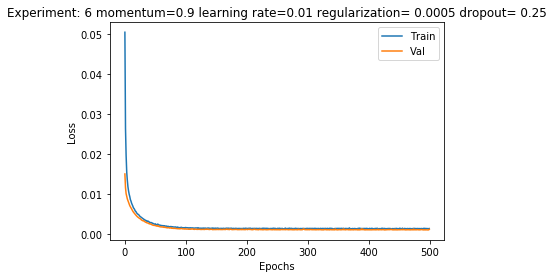

In [32]:
# regularization
exp = 6
l = 0.01
m = 0.9
r = 0.0005
d = 0.25
model_lr_6 = Sequential([
        Dense(output_dim=hidden1_num_units,  activation='tanh', kernel_regularizer=regularizers.l2(r)),
        Dropout(d),
        Dense(output_dim=hidden2_num_units,  activation='tanh', kernel_regularizer=regularizers.l2(r)),
        Dropout(d),
        Dense(output_dim=output_num_units),
 ])
opt = SGD(lr=l, momentum=m)
model_lr_6.compile(loss=vector_mse, optimizer=opt, metrics=[vector_mse,'mse'])
history_6 = model_lr_6.fit(X_train, y_train, epochs=n_ep, batch_size=batch_size, validation_data = (X_val,y_val))
plt.plot(history_6.history['loss'], label = 'train')
plt.plot(history_6.history['val_loss'], label = 'val')
plt.title('Experiment: '+ str(exp)+' momentum='+str(m)+' learning rate='+str(l) + ' regularization= '+str(r) + ' dropout= '+str(d))
plt.legend(['Train', 'Val'], loc='upper right')
plt.xlabel('Epochs')
plt.ylabel('Loss')
#plt.savefig('Test '+ str(exp)+'.png',bbox_inches = 'tight',dpi = 600)
plt.show()

# Test 7

/Users/Veronica/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="tanh", kernel_regularizer=<keras.reg..., units=10)`
  
/Users/Veronica/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="tanh", kernel_regularizer=<keras.reg..., units=10)`
  # Remove the CWD from sys.path while we load stuff.
/Users/Veronica/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(units=8)`
  if sys.path[0] == '':


Train on 832 samples, validate on 209 samples
Epoch 1/500
832/832 [==============================] - 2s 2ms/step - loss: 0.2634 - vector_mse: 0.0164 - mean_squared_error: 0.1309 - val_loss: 0.0146 - val_vector_mse: 0.0035 - val_mean_squared_error: 0.0290
Epoch 2/500
832/832 [==============================] - 1s 742us/step - loss: 0.0062 - vector_mse: 0.0032 - mean_squared_error: 0.0262 - val_loss: 0.0042 - val_vector_mse: 0.0031 - val_mean_squared_error: 0.0254
Epoch 3/500
832/832 [==============================] - 1s 813us/step - loss: 0.0038 - vector_mse: 0.0029 - mean_squared_error: 0.0235 - val_loss: 0.0038 - val_vector_mse: 0.0030 - val_mean_squared_error: 0.0244
Epoch 4/500
832/832 [==============================] - 1s 795us/step - loss: 0.0036 - vector_mse: 0.0027 - mean_squared_error: 0.0223 - val_loss: 0.0037 - val_vector_mse: 0.0028 - val_mean_squared_error: 0.0229
Epoch 5/500
832/832 [==============================] - 1s 684us/step - loss: 0.0035 - vector_mse: 0.0027 - mean_

Epoch 78/500
832/832 [==============================] - 0s 497us/step - loss: 0.0027 - vector_mse: 0.0018 - mean_squared_error: 0.0149 - val_loss: 0.0026 - val_vector_mse: 0.0017 - val_mean_squared_error: 0.0142
Epoch 79/500
832/832 [==============================] - 0s 478us/step - loss: 0.0026 - vector_mse: 0.0017 - mean_squared_error: 0.0142 - val_loss: 0.0026 - val_vector_mse: 0.0017 - val_mean_squared_error: 0.0144
Epoch 80/500
832/832 [==============================] - 0s 460us/step - loss: 0.0026 - vector_mse: 0.0017 - mean_squared_error: 0.0147 - val_loss: 0.0025 - val_vector_mse: 0.0014 - val_mean_squared_error: 0.0117
Epoch 81/500
832/832 [==============================] - 0s 448us/step - loss: 0.0026 - vector_mse: 0.0016 - mean_squared_error: 0.0139 - val_loss: 0.0025 - val_vector_mse: 0.0015 - val_mean_squared_error: 0.0128
Epoch 82/500
832/832 [==============================] - 0s 454us/step - loss: 0.0026 - vector_mse: 0.0017 - mean_squared_error: 0.0142 - val_loss: 0.002

832/832 [==============================] - 0s 499us/step - loss: 0.0024 - vector_mse: 0.0016 - mean_squared_error: 0.0136 - val_loss: 0.0022 - val_vector_mse: 0.0013 - val_mean_squared_error: 0.0114
Epoch 155/500
832/832 [==============================] - 0s 541us/step - loss: 0.0024 - vector_mse: 0.0016 - mean_squared_error: 0.0134 - val_loss: 0.0024 - val_vector_mse: 0.0017 - val_mean_squared_error: 0.0140
Epoch 156/500
832/832 [==============================] - 0s 498us/step - loss: 0.0024 - vector_mse: 0.0016 - mean_squared_error: 0.0133 - val_loss: 0.0023 - val_vector_mse: 0.0015 - val_mean_squared_error: 0.0127
Epoch 157/500
832/832 [==============================] - 0s 457us/step - loss: 0.0023 - vector_mse: 0.0015 - mean_squared_error: 0.0126 - val_loss: 0.0023 - val_vector_mse: 0.0015 - val_mean_squared_error: 0.0125
Epoch 158/500
832/832 [==============================] - 0s 452us/step - loss: 0.0024 - vector_mse: 0.0015 - mean_squared_error: 0.0130 - val_loss: 0.0023 - val_v

832/832 [==============================] - 0s 489us/step - loss: 0.0022 - vector_mse: 0.0015 - mean_squared_error: 0.0127 - val_loss: 0.0021 - val_vector_mse: 0.0013 - val_mean_squared_error: 0.0113
Epoch 231/500
832/832 [==============================] - 0s 461us/step - loss: 0.0023 - vector_mse: 0.0015 - mean_squared_error: 0.0127 - val_loss: 0.0021 - val_vector_mse: 0.0013 - val_mean_squared_error: 0.0113
Epoch 232/500
832/832 [==============================] - 0s 503us/step - loss: 0.0023 - vector_mse: 0.0015 - mean_squared_error: 0.0130 - val_loss: 0.0021 - val_vector_mse: 0.0014 - val_mean_squared_error: 0.0121
Epoch 233/500
832/832 [==============================] - 0s 456us/step - loss: 0.0022 - vector_mse: 0.0015 - mean_squared_error: 0.0126 - val_loss: 0.0021 - val_vector_mse: 0.0013 - val_mean_squared_error: 0.0113
Epoch 234/500
832/832 [==============================] - 0s 479us/step - loss: 0.0023 - vector_mse: 0.0015 - mean_squared_error: 0.0128 - val_loss: 0.0022 - val_v

832/832 [==============================] - 0s 446us/step - loss: 0.0022 - vector_mse: 0.0015 - mean_squared_error: 0.0126 - val_loss: 0.0020 - val_vector_mse: 0.0012 - val_mean_squared_error: 0.0105
Epoch 307/500
832/832 [==============================] - 0s 493us/step - loss: 0.0022 - vector_mse: 0.0014 - mean_squared_error: 0.0123 - val_loss: 0.0020 - val_vector_mse: 0.0014 - val_mean_squared_error: 0.0120
Epoch 308/500
832/832 [==============================] - 0s 506us/step - loss: 0.0021 - vector_mse: 0.0014 - mean_squared_error: 0.0123 - val_loss: 0.0020 - val_vector_mse: 0.0014 - val_mean_squared_error: 0.0119
Epoch 309/500
832/832 [==============================] - 0s 475us/step - loss: 0.0022 - vector_mse: 0.0015 - mean_squared_error: 0.0126 - val_loss: 0.0020 - val_vector_mse: 0.0013 - val_mean_squared_error: 0.0113
Epoch 310/500
832/832 [==============================] - 0s 443us/step - loss: 0.0021 - vector_mse: 0.0014 - mean_squared_error: 0.0121 - val_loss: 0.0020 - val_v

832/832 [==============================] - 0s 396us/step - loss: 0.0021 - vector_mse: 0.0014 - mean_squared_error: 0.0121 - val_loss: 0.0019 - val_vector_mse: 0.0012 - val_mean_squared_error: 0.0105
Epoch 383/500
832/832 [==============================] - 0s 451us/step - loss: 0.0021 - vector_mse: 0.0015 - mean_squared_error: 0.0128 - val_loss: 0.0019 - val_vector_mse: 0.0012 - val_mean_squared_error: 0.0105
Epoch 384/500
832/832 [==============================] - 0s 456us/step - loss: 0.0021 - vector_mse: 0.0014 - mean_squared_error: 0.0123 - val_loss: 0.0019 - val_vector_mse: 0.0013 - val_mean_squared_error: 0.0109
Epoch 385/500
832/832 [==============================] - 0s 468us/step - loss: 0.0021 - vector_mse: 0.0014 - mean_squared_error: 0.0122 - val_loss: 0.0019 - val_vector_mse: 0.0013 - val_mean_squared_error: 0.0114
Epoch 386/500
832/832 [==============================] - 0s 489us/step - loss: 0.0021 - vector_mse: 0.0014 - mean_squared_error: 0.0121 - val_loss: 0.0019 - val_v

832/832 [==============================] - 1s 658us/step - loss: 0.0021 - vector_mse: 0.0015 - mean_squared_error: 0.0127 - val_loss: 0.0018 - val_vector_mse: 0.0011 - val_mean_squared_error: 0.0095
Epoch 459/500
832/832 [==============================] - 0s 537us/step - loss: 0.0020 - vector_mse: 0.0013 - mean_squared_error: 0.0116 - val_loss: 0.0018 - val_vector_mse: 0.0012 - val_mean_squared_error: 0.0106
Epoch 460/500
832/832 [==============================] - 1s 648us/step - loss: 0.0020 - vector_mse: 0.0014 - mean_squared_error: 0.0119 - val_loss: 0.0018 - val_vector_mse: 0.0012 - val_mean_squared_error: 0.0107
Epoch 461/500
832/832 [==============================] - 0s 552us/step - loss: 0.0020 - vector_mse: 0.0014 - mean_squared_error: 0.0117 - val_loss: 0.0019 - val_vector_mse: 0.0013 - val_mean_squared_error: 0.0114
Epoch 462/500
832/832 [==============================] - 0s 497us/step - loss: 0.0020 - vector_mse: 0.0014 - mean_squared_error: 0.0121 - val_loss: 0.0018 - val_v

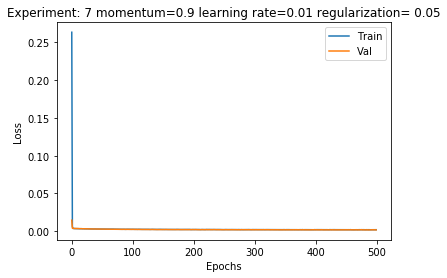

In [71]:
# regularization
exp = 7
l = 0.01
m = 0.9
r = 0.05
#d = 0.25
model_lr_7 = Sequential([
        Dense(output_dim=hidden1_num_units,  activation='tanh', kernel_regularizer=regularizers.l2(r)),
        Dropout(d),
        Dense(output_dim=hidden2_num_units,  activation='tanh', kernel_regularizer=regularizers.l2(r)),
        Dropout(d),
        Dense(output_dim=output_num_units),
 ])
opt = SGD(lr=l, momentum=m)
model_lr_7.compile(loss=vector_mse, optimizer=opt, metrics=[vector_mse,'mse'])
history_7 = model_lr_7.fit(X_train, y_train, epochs=n_ep, batch_size=batch_size, validation_data = (X_val,y_val))
plt.plot(history_7.history['loss'], label = 'train')
plt.plot(history_7.history['val_loss'], label = 'val')
plt.title('Experiment: '+ str(exp)+' momentum='+str(m)+' learning rate='+str(l) + ' regularization= '+str(r) )
plt.legend(['Train', 'Val'], loc='upper right')
plt.xlabel('Epochs')
plt.ylabel('Loss')
#plt.savefig('Test '+ str(exp)+'.png',bbox_inches = 'tight',dpi = 600)
plt.show()

# Define ANN Prediction

In [67]:
model_list = [model_lr_1,model_lr_2, model_lr_3,model_lr_4,model_lr_5,model_lr_6, model_lr_7]

In [34]:
def ANN_Calculate(f_rate,move,model_list,scaler):
    #Create the initial curve
    initial_c = np.repeat(f_rate,8, axis =0)
    
    #Create the input data
    X_unseen = np.array(np.append(initial_c, move))
    X_unseen = X_unseen.reshape(1,9)
    
    #Show the result
    result = np.empty((0,8), int)

    for i in range(len(model_list)):
        # get result
        p = model_list[i].predict(X_unseen)
        # transofrm
        p_Tr= scaler.inverse_transform(p)
        
        # apply back
        p_Tr = initial_c+(p_Tr/100) # apply back to curve
        
        result = np.append(result, p_Tr, axis=0)
    return result


In [35]:
def draw_ANN_Prediction(i_c, arr,flat_rate, movement):
    plt.plot(i_c, marker = '^',label = 'Initial Curve')
    plt.plot(arr[0], marker = 'o',label = 'model 1: m = 0.5, l = 0.1')
    plt.plot(arr[1], marker = 'o',label = 'model 2: m = 0.9, l = 0.1')
    plt.plot(arr[2], marker = 'o',label = 'model 3: m = 0.9, l = 0.01')
    plt.plot(arr[3], marker = 'o',label = 'model 4: m = 0.9, l = 0.01, r = 0.00005')
    plt.plot(arr[4], marker = 'o',label = 'model 5: m = 0.9, l = 0.01, r = 0.0005')
    plt.plot(arr[5], marker = 'o',label = 'model 6: m = 0.9, l = 0.01, r = 0.0005, d = 0.25')

    plt.xlabel('Zero-Coupon Bond Yield Maturities')
    plt.ylabel('Prediction (in percent)')

    plt.xticks(range(8), x_label)

    plt.legend(loc='upper right',  bbox_to_anchor = (1,-0.2))
    plt.title("Interest Rate "+ str(flat_rate) + "% movement prediction for "+ str(movement)+"bps")

    #plt.savefig('Result'+str(result_index)+'.png',bbox_inches = 'tight',dpi = 600)
    plt.show()

# Prediction Observation
## 4% upward

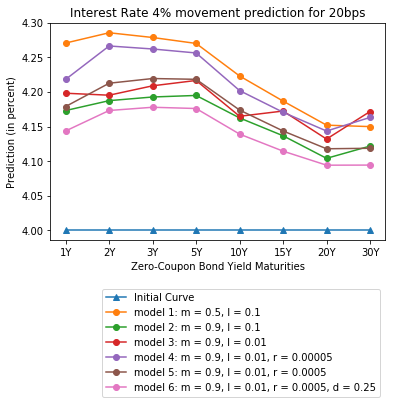

In [36]:
#%matplotlib inline
flat_rate = 4 # change flat rate
movement = 20 #change movement
result_index = 1

prediction_list = ANN_Calculate(flat_rate,movement, model_list, scaler)
i_c= np.repeat(flat_rate,8, axis =0)

draw_ANN_Prediction(i_c,prediction_list,flat_rate, movement)


## 4% downward

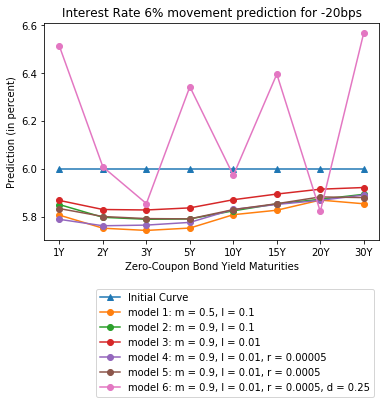

In [74]:
#%matplotlib inline
flat_rate = 6 # change flat rate
movement = -20 #change movement
result_index = 20

prediction_list = ANN_Calculate(flat_rate,movement, model_list, scaler)
i_c= np.repeat(flat_rate,8, axis =0)

draw_ANN_Prediction(i_c,prediction_list,flat_rate, movement)

# 2% upward

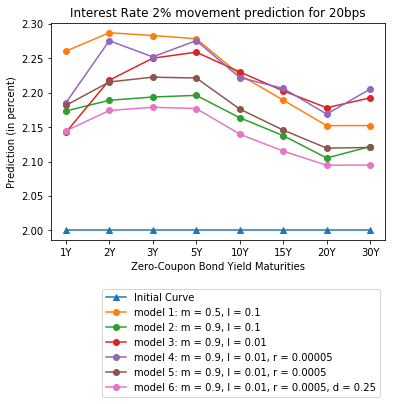

In [38]:
#%matplotlib inline
flat_rate = 2 # change flat rate
movement = 20 #change movement
result_index = 3

prediction_list = ANN_Calculate(flat_rate,movement, model_list, scaler)
i_c= np.repeat(flat_rate,8, axis =0)

draw_ANN_Prediction(i_c,prediction_list,flat_rate, movement)

# 2% downward

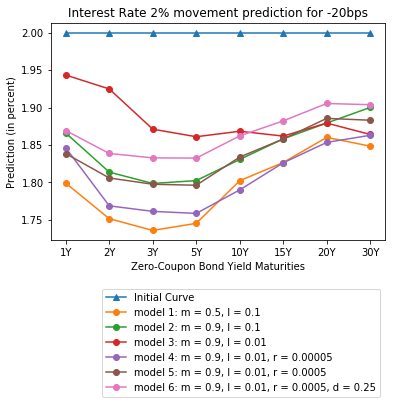

In [39]:
#%matplotlib inline
flat_rate = 2 # change flat rate
movement = -20 #change movement
result_index = 4

prediction_list = ANN_Calculate(flat_rate,movement, model_list, scaler)
i_c= np.repeat(flat_rate,8, axis =0)

draw_ANN_Prediction(i_c,prediction_list,flat_rate, movement)

# PCA Prediction

In [40]:
def PCA_prediction(X):
    inputPCA = np.dot(np.array(eigVec), X[0:8]) 
    chgP = X[8:9]/eigVec[0,PCA_indicator]
    inputPCAChg = np.concatenate((inputPCA[0]+chgP, inputPCA[1:3])) 
    approxPCA =  np.dot(inputPCAChg, eigVec)
    chg_original = approxPCA - X[0:8]
    
    #chg_original = chg_original*10000 # scale the data
    return chg_original

# Comparision with the PCA prediction

In [41]:
# calculate the diff:
error = 0
a = 0
for i in range(len(X_test)):
    prep_PCA = X_test[i,]
    prep_PCA = np.concatenate((prep_PCA[0:8]/100, prep_PCA[8:9]/10000))  # scaled back
    P_1 = PCA_prediction(prep_PCA)
    error = error + 1/8*np.sum(((P_1 - y_test[i,]/10000)**2))
    
print("PCA MSE is", error)

PCA MSE is 0.0016145685457485178


In [42]:
def calculate_ANN_MSE (y_p, y_t):
    error_ANN = 0
    error_sing = 0
    for i in range(len(y_test)):
        error_ANN = error_ANN + 1/8*np.sum((y_p[i,]/10000-y_t[i,]/10000)**2)
        #error_sing = error_sing + (y_pred[i,3]/10000-y_test[i,3]/10000)**2
    return error_ANN

In [43]:
# Get Prediction
y_pred_list=[]
for i in model_list:
    y_pred = i.predict(X_test)
    y_pred= scaler.inverse_transform(y_pred)
    y_pred_list.append(y_pred)
    
model_original = scaler.inverse_transform(y_test)

In [44]:
print ("Model 1: ", calculate_ANN_MSE(y_pred_list[0], model_original))
print ("Model 2: ", calculate_ANN_MSE(y_pred_list[1], model_original))
print ("Model 3: ", calculate_ANN_MSE(y_pred_list[2], model_original))
print ("Model 4: ", calculate_ANN_MSE(y_pred_list[3], model_original))
print ("Model 5: ", calculate_ANN_MSE(y_pred_list[4], model_original))
print ("Model 6: ", calculate_ANN_MSE(y_pred_list[5], model_original))

Model 1:  0.000292638515071085
Model 2:  0.0003048291928782954
Model 3:  0.00031701034330757264
Model 4:  0.00028866095376940936
Model 5:  0.00029069565632568076
Model 6:  0.00030643162400880504


# Compared  ANN vs PCA

In [45]:
# draw ANN vs PCA
def draw_ANN_PCA_diff(ANN_pos, ANN_neg, PCA_pos,PCA_neg, move,f_rate, i):
    plt.plot(i_c, marker = '^',label = 'Initial Curve')
    plt.plot(ANN_pos, marker = 'o',label = 'ANN Prediction +'+str(move)+'bps')
    plt.plot(ANN_neg, marker = 'o',label = 'ANN Prediction -'+str(move)+'bps')
    plt.plot(PCA_pos, marker = 'v',label = 'PCA Prediction +'+str(move)+'bps')
    plt.plot(PCA_neg, marker = 'v',label = 'PCA Prediction -'+str(move)+'bps')

    plt.xlabel('PCA vs ANN Prediction')
    plt.xticks(range(8), x_label)
    plt.ylabel('Yield (in percent)')
    plt.legend(loc='upper center', bbox_to_anchor = (1.5,1))
    plt.title("Interest Rate "+str(f_rate)+"% movement prediction for +/- "+str(move)+"bps")

    plt.savefig('PCA vs ANN'+str(i)+'.png', bbox_inches = 'tight',dpi = 600)
    plt.show()

## interest rate 1% 20 bps

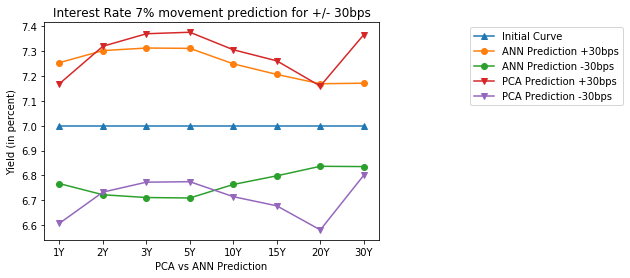

In [76]:
#%matplotlib inline
flat_rate = 7 # change flat rate
movement = 30 #change movement
result_index = 1

initial_c= np.repeat(flat_rate/100,8, axis =0)
X_unseen= np.array(np.append(initial_c, movement/10000))
PCA_pos= (PCA_prediction(X_unseen)+initial_c)*100

X_unseen= np.array(np.append(initial_c, -movement/10000))
PCA_neg= (PCA_prediction(X_unseen)+initial_c)*100

arr_pos = ANN_Calculate(flat_rate,movement, model_list, scaler)
arr_neg = ANN_Calculate(flat_rate,-movement, model_list, scaler)
i_c= initial_c*100

draw_ANN_PCA_diff(arr_pos[4],arr_neg[4],PCA_pos, PCA_neg,movement,flat_rate,result_index)


In [58]:
arr_pos[4],arr_neg[4]

(array([1.18284605, 1.21722193, 1.22427936, 1.22298758, 1.17759235,
        1.14680214, 1.12040666, 1.12143931]),
 array([0.83948115, 0.80708586, 0.79876466, 0.79740876, 0.83480011,
        0.85878327, 0.8861976 , 0.88378663]))

In [59]:
PCA_pos, PCA_neg

(array([1.17082345, 1.19889736, 1.20879634, 1.21072958, 1.19799615,
        1.18960856, 1.17391995, 1.19997676]),
 array([0.79722481, 0.80855519, 0.81152731, 0.81072958, 0.80481754,
        0.80160665, 0.78900238, 0.82380078]))

## Interest Rate 4%

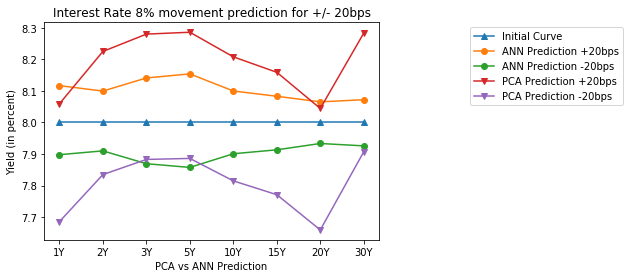

In [72]:
#%matplotlib inline
flat_rate = 8 # change flat rate
movement = 20 #change movement
result_index = 2

initial_c= np.repeat(flat_rate/100,8, axis =0)
X_unseen= np.array(np.append(initial_c, movement/10000))
PCA_pos= (PCA_prediction(X_unseen)+initial_c)*100

X_unseen= np.array(np.append(initial_c, -movement/10000))
PCA_neg= (PCA_prediction(X_unseen)+initial_c)*100

arr_pos = ANN_Calculate(flat_rate,movement, model_list, scaler)
arr_neg = ANN_Calculate(flat_rate,-movement, model_list, scaler)
i_c= initial_c*100

draw_ANN_PCA_diff(arr_pos[6],arr_neg[6],PCA_pos, PCA_neg,movement,flat_rate,result_index)

In [56]:
arr_pos[4],arr_neg[4]

(array([3.1803482 , 3.21424459, 3.22111042, 3.21993677, 3.17518267,
        3.14477241, 3.11881405, 3.11963578]),
 array([2.83736643, 2.80461681, 2.79614346, 2.79487474, 2.83280391,
        2.85707432, 2.88484886, 2.88232149]))

In [62]:
PCA_pos, PCA_neg

(array([3.13887172, 3.20634991, 3.22911999, 3.23218874, 3.20080984,
        3.18082377, 3.13684229, 3.2237543 ]),
 array([2.76527308, 2.81600773, 2.83185096, 2.83218874, 2.80763122,
        2.79282187, 2.75192471, 2.84757832]))

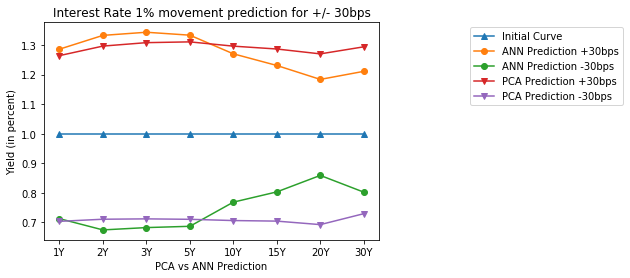

In [58]:
%matplotlib inline
flat_rate = 1 # change flat rate
movement = 30 #change movement
result_index = 3

initial_c= np.repeat(flat_rate/100,8, axis =0)
X_unseen= np.array(np.append(initial_c, movement/10000))
PCA_pos= (PCA_prediction(X_unseen)+initial_c)*100

X_unseen= np.array(np.append(initial_c, -movement/10000))
PCA_neg= (PCA_prediction(X_unseen)+initial_c)*100

arr_pos = ANN_Calculate(flat_rate,movement, model_list, scaler)
arr_neg = ANN_Calculate(flat_rate,-movement, model_list, scaler)
i_c= initial_c*100

draw_ANN_PCA_diff(arr_pos[4],arr_neg[4],PCA_pos, PCA_neg,movement,flat_rate,result_index)
